# Original data sets can be found at :
Open Food Facts
https://www.kaggle.com/openfoodfacts/world-food-facts

General Recipes
https://www.kaggle.com/hugodarwood/epirecipes

Christmas Recipes
https://www.kaggle.com/gjbroughton/christmas-recipes


### pyspark.sql module documentation
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, CountVectorizer
import pandas as pd

In [13]:
#create spark session
spark = SparkSession.builder.appName('Spark Recipes').getOrCreate()
sc = spark.sparkContext
spark

### Christmas Recipes

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [15]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [16]:
df_chrisrecipes = spark.read.json("gs://big_data_vht/Christmas recipes.json")
#df_chrisrecipes = spark.read.json("/user/alvinharyanto/data/Christmas_recipes.json")

In [17]:
df_chrisrecipes.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)



In [18]:
#Show single column
df_chrisrecipes.select("Name","Ingredients").show(10)

+--------------------+--------------------+
|                Name|         Ingredients|
+--------------------+--------------------+
|       Christmas pie|[2 tbsp olive oil...|
|Simmer-&-stir Chr...|[175g butter, cho...|
|  Christmas cupcakes|[200g dark muscov...|
|      Christmas buns|[500g strong whit...|
|  Christmas cupcakes|[280g self-raisin...|
|      Christmas slaw|[2 carrots, halve...|
|      Christmas mess|l double cre...|
|  Christmas brownies|[200g unsalted bu...|
|Christmas cosmopo...|l vodka, 500...|
|     Christmas pizza|[145g pizza basem...|
+--------------------+--------------------+
only showing top 10 rows



In [19]:
df_chrisrecipes.limit(2).toPandas()

,Author,Description,Ingredients,Method,Name,url
0,Mary Cadogan,Combine a few key Christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...
1,Mary Cadogan,An easy-to-make alternative to traditional Chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...


In [20]:
df_chrisrecipes.select('Ingredients').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Ingredients                                                                                                                                                                                                                                                                                                                                                                                                       

In [21]:
import pyspark.sql.functions as f
counts = df_chrisrecipes.select(f.explode('Ingredients').alias('Ingredient')).groupBy('Ingredient').count().orderBy('count',ascending=0)
counts.show(truncate=False)

+-------------------------+-----+
|Ingredient               |count|
+-------------------------+-----+
|2 tbsp olive oil         |76   |
|50g butter               |75   |
|1 egg, beaten            |71   |
|25g butter               |65   |
|1 tbsp olive oil         |60   |
|1 tsp vanilla extract    |52   |
|1 tsp ground cinnamon    |49   |
|icing sugar, for dusting |40   |
|2 bay leaves             |37   |
|100g golden caster sugar |36   |
|1 cinnamon stick         |35   |
|2 garlic cloves, crushed |33   |
|1 tsp mixed spice        |32   |
|3 tbsp olive oil         |32   |
|1 garlic clove, crushed  |31   |
|1 tsp baking powder      |30   |
|1 bay leaf               |27   |
|1 tsp bicarbonate of soda|26   |
|50g plain flour          |25   |
|2 eggs                   |24   |
+-------------------------+-----+
only showing top 20 rows



In [22]:
counts.count()

10116

In [23]:
from pyspark.sql.functions import *
#Removing measurement terms used in cooking
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', '[0-9]+g', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', '[0-9]+ml', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', '[0-9]+kg', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', 'tbsp', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', '[0-9]', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', 'tsp', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', 'lb', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', 'oz', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', 'pt', ''))
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', 'qt', ''))
#Removing fractions
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient', '[^\w\d\s\,]', ''))
#Removing words after ','
counts = counts.withColumn('Ingredient',split('Ingredient', ', ')[0])
#removing whitespace from words
from pyspark.sql.functions import trim
counts = counts.withColumn('Ingredient', trim(counts.Ingredient))
#removing 's' from plural form of words
counts = counts.withColumn('Ingredient', regexp_replace('Ingredient','s$', ''))

counts.show(50, truncate=False)

+-------------------+-----+
|Ingredient         |count|
+-------------------+-----+
|olive oil          |76   |
|butter             |75   |
|egg                |71   |
|butter             |65   |
|olive oil          |60   |
|vanilla extract    |52   |
|ground cinnamon    |49   |
|icing sugar        |40   |
|bay leave          |37   |
|golden caster sugar|36   |
|cinnamon stick     |35   |
|garlic clove       |33   |
|mixed spice        |32   |
|olive oil          |32   |
|garlic clove       |31   |
|baking powder      |30   |
|bay leaf           |27   |
|bicarbonate of soda|26   |
|plain flour        |25   |
|egg                |24   |
|plain flour        |24   |
|olive oil          |23   |
|golden caster sugar|22   |
|ground cinnamon    |22   |
|golden caster sugar|22   |
|baking powder      |22   |
|zest  lemon        |22   |
|large egg          |22   |
|caster sugar       |22   |
|zest  orange       |21   |
|onion              |21   |
|plain flour        |21   |
|large egg          

In [24]:
acounts = counts.withColumnRenamed("count", "Total")

In [25]:
acounts.show(truncate=False)

+-------------------+-----+
|Ingredient         |Total|
+-------------------+-----+
|olive oil          |76   |
|butter             |75   |
|egg                |71   |
|butter             |65   |
|olive oil          |60   |
|vanilla extract    |52   |
|ground cinnamon    |49   |
|icing sugar        |40   |
|bay leave          |37   |
|golden caster sugar|36   |
|cinnamon stick     |35   |
|garlic clove       |33   |
|olive oil          |32   |
|mixed spice        |32   |
|garlic clove       |31   |
|baking powder      |30   |
|bay leaf           |27   |
|bicarbonate of soda|26   |
|plain flour        |25   |
|egg                |24   |
+-------------------+-----+
only showing top 20 rows



In [26]:
#recounting and grouping by Ingredient again
from pyspark.sql import functions as func
counts = acounts.groupBy("Ingredient").agg(func.sum("Total")).orderBy(["sum(Total)"], ascending=[0])

counts.show(50, truncate=False)

+---------------------+----------+
|Ingredient           |sum(Total)|
+---------------------+----------+
|butter               |494       |
|plain flour          |309       |
|olive oil            |275       |
|egg                  |243       |
|golden caster sugar  |237       |
|icing sugar          |226       |
|garlic clove         |214       |
|double cream         |167       |
|caster sugar         |156       |
|onion                |153       |
|large egg            |142       |
|milk                 |125       |
|unsalted butter      |115       |
|ground cinnamon      |99        |
|selfraising flour    |97        |
|sunflower oil        |88        |
|light muscovado sugar|88        |
|vanilla extract      |85        |
|baking powder        |81        |
|bay leave            |75        |
|brandy               |69        |
|mixed spice          |68        |
|shallot              |67        |
|lemon                |67        |
|carrot               |65        |
|ground almond      

In [27]:
#exporting to csv
#counts.coalesce(1).write.option("header","true").csv("gs://big_data_vht/christmas_counts.csv")

## Prepping the Open Food Facts table for merge with Christmas Recipes

In [28]:
df_ofoodfacts = spark.read.csv("gs://big_data_vht/reduced_OpenFoodFacts.csv", inferSchema=True, header=True)

In [212]:
df_ofoodfacts001 = spark.read.csv("gs://big_data_vht/reduced_OpenFoodFacts.csv", inferSchema=True, header=True)

In [213]:
df_ofoodfacts001.limit(3).toPandas()

,product_name,brands,countries_en,ingredients_text,serving_size,serving_quantity,num_additives,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_pal,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamina_100g,vitaminc_100g,calcium_100g,iron_100g
0,banana chips sweetened (whole),nan,united states,"bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 onz),28.0,0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,0.0,0.0,...,64.29,14.29,3.6,3.5699998999999996,0.0,0.0,0.0,0.021400001000000002,0.0,0.0012900000000000001
1,peanuts,torn & glasser,united states,"peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),28.0,0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0.0,0.0,...,60.71,17.86,7.1,17.860001,0.635,0.25,0.0,0.0,0.071000002,0.0012900000000000001
2,organic salted nut mix,grizzlies,united states,"organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),28.0,0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,0.0,0.0,...,17.86,3.57,7.1,17.860001,1.22428,0.48200000000000004,2.0976923846153848e-05,0.000675000025,0.14300001,0.00514


In [29]:
df_ofoodfacts = df_ofoodfacts.dropna(subset=['product_name']).dropDuplicates(subset=['product_name'])

In [30]:
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', lower(col('product_name')))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', 'Organic', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\(', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\)', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\-', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\.', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '100\%', ''))

## Creating open food facts sub table for top 20 Christmas ingredients

In [31]:
df_ofoodfacts.createOrReplaceTempView("df_ofoodfacts")

In [32]:
chris_facts=spark.sql("SELECT product_name, energy_100g, fat_100g, saturatedfat_100g, transfat_100g, cholesterol_100g, \
carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, vitamina_100g, vitaminc_100g, \
calcium_100g, iron_100g, CASE WHEN product_name = 'butter' THEN 'butter' WHEN product_name = 'flour' \
THEN 'flour' WHEN product_name = 'olive oil' THEN 'olive oil' WHEN product_name = 'egg' THEN 'egg' \
WHEN product_name = 'sugar' THEN 'sugar' WHEN product_name  = 'garlic cloves' THEN 'garlic cloves' \
WHEN product_name = 'cream' THEN 'cream' WHEN product_name = 'onion' THEN 'onion' \
WHEN product_name = 'milk' THEN 'milk' WHEN product_name = 'cinnamon' THEN 'cinnamon' \
WHEN product_name = 'sunflower oil' THEN 'sunflower oil' WHEN product_name = 'vanilla extract' THEN 'vanilla extract' \
WHEN product_name = 'baking powder' THEN 'baking powder' WHEN product_name = 'honey' THEN 'honey' \
WHEN product_name = 'lemon' THEN 'lemon' WHEN product_name LIKE 'shallots' THEN 'shallots' \
WHEN product_name = 'almond' THEN 'almond' WHEN product_name LIKE 'syrup' THEN 'syrup' \
WHEN product_name = 'dark chocolate' THEN 'dark chocolate' WHEN product_name = 'vegetable oil' THEN 'vegetable oil' \
END AS key1 FROM df_ofoodfacts SORT by key1 ASC")

In [33]:
test=spark.sql("SELECT product_name, energy_100g, fat_100g, saturatedfat_100g, transfat_100g, cholesterol_100g, \
carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, vitamina_100g, vitaminc_100g, \
calcium_100g, iron_100g FROM df_ofoodfacts WHERE product_name  = 'lemon'")
test.show()

+------------+-----------+--------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+--------------------+
|product_name|energy_100g|fat_100g|saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|salt_100g|sodium_100g|vitamina_100g|vitaminc_100g|calcium_100g|           iron_100g|
+------------+-----------+--------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+--------------------+
|       lemon|     1569.0|     0.0|              0.0|          0.0|             0.0|             100.0|      100.0|       2.1|          0.0|      0.0|        0.0|          0.0| 0.0024999999|         0.0|0.000750000009999...|
+------------+-----------+--------+-----------------+-------------+----------------+----------------

In [34]:
chris_facts.createOrReplaceTempView("chris_facts")
chris_facts2=spark.sql("SELECT * \
FROM chris_facts \
WHERE key1 IS NOT NULL \
sort by key1 ASC")

In [35]:
chris_facts2.createOrReplaceTempView("chris_facts2")

In [36]:
chris_facts3=spark.sql("SELECT * \
FROM chris_facts2 \
WHERE key1 ='sunflower oil' \
sort by key1 ASC")
chris_facts3.show()

+-------------+-----------+--------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+---------+-------------+
| product_name|energy_100g|fat_100g|saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|salt_100g|sodium_100g|vitamina_100g|vitaminc_100g|calcium_100g|iron_100g|         key1|
+-------------+-----------+--------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+---------+-------------+
|sunflower oil|     3586.0|   100.0|            10.71|          0.0|             0.0|               0.0|        0.0|       0.0|          0.0|      0.0|        0.0|          0.0|          0.0|         0.0|      0.0|sunflower oil|
+-------------+-----------+--------+-----------------+-------------+----------------

In [37]:
chris1=spark.sql("SELECT * FROM chris_facts2 WHERE key1='dark chocolate' LIMIT 1" )
chris2=spark.sql("SELECT * FROM chris_facts2 WHERE key1='cream' LIMIT 1" )
chris3=spark.sql("SELECT * FROM chris_facts2 WHERE key1='milk' LIMIT 1" )
chris4=spark.sql("SELECT * FROM chris_facts2 WHERE key1='egg' LIMIT 1" )
chris5=spark.sql("SELECT * FROM chris_facts2 WHERE key1='syrup' LIMIT 1" )
chris6=spark.sql("SELECT * FROM chris_facts2 WHERE key1='honey' LIMIT 1" )
chris7=spark.sql("SELECT * FROM chris_facts2 WHERE key1='cinnamon' LIMIT 1" )
chris8=spark.sql("SELECT * FROM chris_facts2 WHERE key1='butter' LIMIT 1" )
chris9=spark.sql("SELECT * FROM chris_facts2 WHERE key1='sunflower oil' LIMIT 1" )
chris10=spark.sql("SELECT * FROM chris_facts2 WHERE key1='olive oil' LIMIT 1" )
chris11=spark.sql("SELECT * FROM chris_facts2 WHERE key1='vegetable oil' LIMIT 1" )
chris12=spark.sql("SELECT * FROM chris_facts2 WHERE key1='almond' LIMIT 1" )
chris13=spark.sql("SELECT * FROM chris_facts2 WHERE key1='lemon' LIMIT 1" )
chris14=spark.sql("SELECT * FROM chris_facts2 WHERE key1='shallots' LIMIT 1" )
chris15=spark.sql("SELECT * FROM chris_facts2 WHERE key1='vanilla extract' LIMIT 1" )
chris16=spark.sql("SELECT * FROM chris_facts2 WHERE key1='baking powder' LIMIT 1" )
chris17=spark.sql("SELECT * FROM chris_facts2 WHERE key1='garlic cloves' LIMIT 1" )
chris18=spark.sql("SELECT * FROM chris_facts2 WHERE key1='flour' LIMIT 1" )
chris19=spark.sql("SELECT * FROM chris_facts2 WHERE key1='sugar' LIMIT 1" )
chris20=spark.sql("SELECT * FROM chris_facts2 WHERE key1='onion' LIMIT 1" )

In [38]:
chris18.show()

+------------+-----------+--------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+--------------------+-----+
|product_name|energy_100g|fat_100g|saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|salt_100g|sodium_100g|vitamina_100g|vitaminc_100g|calcium_100g|           iron_100g| key1|
+------------+-----------+--------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+--------------------+-----+
|       flour|     1393.0|     0.0|              0.0|          0.0|             0.0|             73.33|       3.33|       3.3|         10.0|  2.71018|      1.067|          0.0|          0.0|       0.133|0.004800000200000...|flour|
+------------+-----------+--------+-----------------+-------------+---------

In [39]:
chris_ing_table=chris1.union(chris2)
chris_ing_table=chris_ing_table.union(chris3)
chris_ing_table=chris_ing_table.union(chris4)
chris_ing_table=chris_ing_table.union(chris5)
chris_ing_table=chris_ing_table.union(chris6)
chris_ing_table=chris_ing_table.union(chris7)
chris_ing_table=chris_ing_table.union(chris8)
chris_ing_table=chris_ing_table.union(chris9)
chris_ing_table=chris_ing_table.union(chris10)
chris_ing_table=chris_ing_table.union(chris11)
chris_ing_table=chris_ing_table.union(chris12)
chris_ing_table=chris_ing_table.union(chris13)
chris_ing_table=chris_ing_table.union(chris14)
chris_ing_table=chris_ing_table.union(chris15)
chris_ing_table=chris_ing_table.union(chris16)
chris_ing_table=chris_ing_table.union(chris17)
chris_ing_table=chris_ing_table.union(chris18)
chris_ing_table=chris_ing_table.union(chris19)
chris_ing_table=chris_ing_table.union(chris20)
print(chris_ing_table.count())
chris_ing_table.show()

20
+---------------+-----------+------------------+------------------+-------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|   product_name|energy_100g|          fat_100g| saturatedfat_100g|transfat_100g|    cholesterol_100g|carbohydrates_100g|       sugars_100g|        fiber_100g|    proteins_100g|           salt_100g|         sodium_100g|       vitamina_100g|       vitaminc_100g|        calcium_100g|           iron_100g|           key1|
+---------------+-----------+------------------+------------------+-------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
| dark chocolate|     2260.0|        

In [40]:
#exporting to csv
chris_ing_table.coalesce(1).write.option("header","true").csv("gs://big_data_vht/ofood_for_chris.csv")

## Merging the open food facts table of the top christmas ingredients with the christmas recipes

In [41]:
chris_ing_table = spark.read.csv("gs://big_data_vht/ofood_for_chris.csv", inferSchema=True, header=True)

In [42]:
chris_ing_table.show(5)

+--------------+-----------+---------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+-------------------+-------------------+--------------------+-------------+------------+---------+--------------+
|  product_name|energy_100g| fat_100g|saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|          salt_100g|        sodium_100g|       vitamina_100g|vitaminc_100g|calcium_100g|iron_100g|          key1|
+--------------+-----------+---------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+-------------------+-------------------+--------------------+-------------+------------+---------+--------------+
|dark chocolate|     2301.0|     35.0|             20.0|          0.0|           0.025|              50.0|       47.5|       7.5|          5.0|0.09652000000000001|              0.038|                 0.0|          0.0|         0.

In [43]:
#exploding the ingredients column
from pyspark import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode

In [44]:
df_chrisrecipes_v1 = df_chrisrecipes.select("Name",'Ingredients')

In [45]:
df_chrisrecipes_v1.show(1,truncate=False)

+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Name         |Ingredients                                                                                                                                                                                                                                                                                                                                                                                                                      |
+-------------+---------------------------------------------------------------------------------------------------------------------

In [46]:
df_chrisrecipes_v2 = df_chrisrecipes_v1.withColumn('Ingredients', explode('Ingredients'))

In [47]:
#replacing the value similar with keys in the column
#dropping values with null in nutrients columns
df_chrisrecipes_v3 = df_chrisrecipes_v2.withColumn('Ingredients', regexp_replace('Ingredients', '.*olive oil.*', 'olive oil'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*butter.*', 'butter'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*dark chocolate.*', 'dark chocolate'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*cream.*', 'cream'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*milk.*', 'milk'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*egg.*', 'egg'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*syrup.*', 'syrup'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*honey.*', 'honey'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*cinnamon.*', 'cinnamon'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*butter.*', 'butter'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*sunflower oil.*', 'sunflower oil'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*vegetable oil.*', 'vegetable oil'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*almond.*', 'almond'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*lemon.*', 'lemon'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*shallot.*', 'shallots'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*vanilla extract.*', 'vanilla extract'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*baking powder.*', 'baking powder'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*garlic clove.*', 'garlic cloves'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*flour.*', 'flour'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*sugar.*', 'sugar'))
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumn('Ingredients', regexp_replace('Ingredients', '.*onion.*', 'onion'))

df_chrisrecipes_v3.show(5)

+-------------+--------------------+
|         Name|         Ingredients|
+-------------+--------------------+
|Christmas pie|           olive oil|
|Christmas pie|              butter|
|Christmas pie|               onion|
|Christmas pie|500g sausagemeat ...|
|Christmas pie|               lemon|
+-------------+--------------------+
only showing top 5 rows



In [48]:
#merging!
#renaming column
df_chrisrecipes_v3 = df_chrisrecipes_v3.withColumnRenamed("Ingredients","key1")
df_chrisrecipes_v3.show(5)

+-------------+--------------------+
|         Name|                key1|
+-------------+--------------------+
|Christmas pie|           olive oil|
|Christmas pie|              butter|
|Christmas pie|               onion|
|Christmas pie|500g sausagemeat ...|
|Christmas pie|               lemon|
+-------------+--------------------+
only showing top 5 rows



In [49]:
#joining chrismas recipes table with top ingredients open food facts table
res = df_chrisrecipes_v3.join(chris_ing_table, "key1")
res.show(10)

+---------+--------------------+------------+-----------+-----------------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+------------------+-----------+--------------------+-------------+--------------------+--------------------+
|     key1|                Name|product_name|energy_100g|         fat_100g|saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|         salt_100g|sodium_100g|       vitamina_100g|vitaminc_100g|        calcium_100g|           iron_100g|
+---------+--------------------+------------+-----------+-----------------+-----------------+-------------+----------------+------------------+-----------+----------+-------------+------------------+-----------+--------------------+-------------+--------------------+--------------------+
|olive oil|       Christmas pie|   olive oil|     3347.0|93.33000200000001|            13.33|          0.0|             0.0|         

In [50]:
res.count()

6363

In [51]:
#aggregating the nutrients column and grouping by recipe name
christmas_table = res.groupBy("Name").agg(func.sum("energy_100g").alias("energy"), func.sum("fat_100g").alias("fat"),
func.sum( "saturatedfat_100g").alias("saturatedfat"), func.sum("transfat_100g").alias("transfat"),
func.sum("cholesterol_100g").alias("cholesterol"), func.sum("carbohydrates_100g").alias("carbs"), func.sum("sugars_100g").alias("sugars"), 
func.sum("fiber_100g").alias("fiber"), func.sum("proteins_100g").alias("protein"),func.sum("salt_100g").alias("salt"),
func.sum("sodium_100g").alias("sodium"), func.sum("vitamina_100g").alias("vit_a"), func.sum("vitaminc_100g").alias("vit_c"), 
func.sum("calcium_100g").alias("calcium"), func.sum("iron_100g").alias("iron"))
christmas_table.show(10)

+--------------------+-------+------------------+------------------+--------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|                Name| energy|               fat|      saturatedfat|transfat|        cholesterol|             carbs|            sugars|             fiber|           protein|              salt|             sodium|               vit_a|               vit_c|            calcium|                iron|
+--------------------+-------+------------------+------------------+--------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|       Reindeer food| 6619.0|             100.0|21.247307646153846|     0.0|             0.0075|188.32999999999

In [52]:
#exporting to csv
#christmas_table.coalesce(1).write.option("header","true").csv("gs://big_data_vht/final_chris_table.csv")

# General Recipes

In [53]:
df_regrecipes = spark.read.csv("gs://big_data_vht/Cleaned_General_Recipe.csv", inferSchema=True, header=True)
#df_regrecipes = spark.read.csv('/user/alvinharyanto/data/Cleaned_General_Recipe.csv', inferSchema=True, header=True)
df_regrecipes.describe()

DataFrame[summary: string, title: string, Ingredients: string]

In [54]:
df_regrecipes.show(4,truncate=False)

+-------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                      |Ingredients                                                                                                                                          |
+-------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|Lentil, Apple, and Turkey Wrap             |apple bean cookie fruit kid-friendly lentil lettuce sandwich tomato vegetable turkey                                                                 |
|Boudin Blanc Terrine with Red Onion Confit |bake bastille day bon appétit chill dried fruit food processor new year's eve onion pork port winter                                                 |
|Potato and Fennel S

In [55]:
df_regrecipes.count()

20057

In [56]:
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'free', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'bon', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'appétit', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'free', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'tree', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'nut', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'vegetarian', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'gourmet', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'kosher', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'pescatarian', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', '&', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'quick', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'easy', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'diary', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'bake', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'summer', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'dessert', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'wheat', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'gluten', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', '\/', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'dairy', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'low', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'side', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'no', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'added', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'winter', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'fall', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'fruit', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'dinner', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'conscious', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'healthy', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'kidney', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'friendly', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'vegetable', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'party', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'fat', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'vegan', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'kid-', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'sauté ', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', '\-', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'spring', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'salad', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'herb', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'cocktail', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'thanksgiving', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'appetizer', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'christmas', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'sauce', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'lunch', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'protein', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'roast', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'grill', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'chill', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'stew', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'cook', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'soup', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'drink', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'barbecue', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'wine', ''))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', ' cal ', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'green', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'condiment', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'high', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'fiber', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'food', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'processor', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'backyard', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'bbq', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'spread', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'leafy', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'simmer', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'day', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'bean', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'juice', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'alcoholic', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'bell', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'cake', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'brunch', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'paleo', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'breakfast', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'spice', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'poultry', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'pea', ' '))
df_regrecipes = df_regrecipes.withColumn('Ingredients', regexp_replace('Ingredients', 'citrus', ' '))
df_regrecipes.show(4,truncate=False)

+-------------------------------------------+---------------------------------------------------------+
|title                                      |Ingredients                                              |
+-------------------------------------------+---------------------------------------------------------+
|Lentil, Apple, and Turkey Wrap             |apple   ie   lentil lettuce sandwich tomato  turkey      |
|Boudin Blanc Terrine with Red Onion Confit | bastille      dried      new year's eve onion pork port |
|Potato and Fennel Soup Hodge               | fennel  new york potato                                 |
|Mahi-Mahi in Tomato Olive Sauce            |     fish          olive       soy  tomato               |
+-------------------------------------------+---------------------------------------------------------+
only showing top 4 rows



### Getting General Recipe Ingredient Count to find out 20 most used ingredients

In [57]:
df_regrecipes.show(3,truncate=False)

+-------------------------------------------+---------------------------------------------------------+
|title                                      |Ingredients                                              |
+-------------------------------------------+---------------------------------------------------------+
|Lentil, Apple, and Turkey Wrap             |apple   ie   lentil lettuce sandwich tomato  turkey      |
|Boudin Blanc Terrine with Red Onion Confit | bastille      dried      new year's eve onion pork port |
|Potato and Fennel Soup Hodge               | fennel  new york potato                                 |
+-------------------------------------------+---------------------------------------------------------+
only showing top 3 rows



In [58]:
gen_rec_count=df_regrecipes.select(explode(split(col("Ingredients"), "\s+")).alias("gen_rec_ing")).groupBy('gen_rec_ing').count().orderBy("count", ascending=False)

In [59]:
gen_rec_count_table=gen_rec_count.limit(30)
gen_rec_count_table.show(30)


+-----------+-----+
|gen_rec_ing|count|
+-----------+-----+
|           |27235|
|        soy| 8491|
|      sugar| 5971|
|      cream| 2947|
|     cheese| 2386|
|      onion| 2354|
|     tomato| 2140|
|     pepper| 2103|
|       milk| 1994|
|        egg| 1777|
|     garlic| 1643|
|     potato| 1416|
|    chicken| 1344|
|      lemon| 1258|
|       pork| 1198|
|     ginger| 1146|
|       beef| 1043|
|      pasta|  980|
|       fish|  936|
|     orange|  889|
|  chocolate|  855|
|   mushroom|  843|
|     carrot|  701|
|       lime|  679|
|      apple|  672|
|    vinegar|  657|
|   parmesan|  644|
|    mustard|  636|
|      mixer|  630|
|    blender|  617|
+-----------+-----+



In [60]:
gen_rec_count_table.describe()

DataFrame[summary: string, gen_rec_ing: string, count: string]

### Downloading General Recipe Ingredient Count Table to GCP Bucket

In [61]:
#gen_rec_count_table.coalesce(1).write.option("header","true").csv("gs://big_data_vht/generalrecipecount")


### Adding Column to General Recipes and Filling it with Primary Key-Prepping for Merge with Open Food 

In [62]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType

df_regrecipes.show(5)


+--------------------+--------------------+
|               title|         Ingredients|
+--------------------+--------------------+
|Lentil, Apple, an...|apple   ie   lent...|
|Boudin Blanc Terr...| bastille      dr...|
|Potato and Fennel...| fennel  new york...|
|Mahi-Mahi in Toma...|     fish        ...|
|Spinach Noodle Ca...|   california che...|
+--------------------+--------------------+
only showing top 5 rows



In [63]:
df_gen=df_regrecipes
print(df_gen.count())
df_gen.show(5)

20057
+--------------------+--------------------+
|               title|         Ingredients|
+--------------------+--------------------+
|Lentil, Apple, an...|apple   ie   lent...|
|Boudin Blanc Terr...| bastille      dr...|
|Potato and Fennel...| fennel  new york...|
|Mahi-Mahi in Toma...|     fish        ...|
|Spinach Noodle Ca...|   california che...|
+--------------------+--------------------+
only showing top 5 rows



In [64]:
df_1=df_regrecipes.filter("Ingredients like '%chocolate%'").withColumn('key1', lit('chocolate'))
df_2=df_regrecipes.filter("Ingredients like '%soy%'").withColumn('key2',lit( 'soy'))
df_3=df_regrecipes.filter("Ingredients like '%sugar%'").withColumn('key3',lit( 'sugar'))
df_4=df_regrecipes.filter("Ingredients like '%cream%'").withColumn('key4',lit( 'cream'))
df_5=df_regrecipes.filter("Ingredients like '%cheese%'").withColumn('key5',lit( 'cheese'))
df_6=df_regrecipes.filter("Ingredients like '%onion%'").withColumn('key6',lit( 'onion'))
df_7=df_regrecipes.filter("Ingredients like '%tomato%'").withColumn('key7',lit( 'tomato'))
df_8=df_regrecipes.filter("Ingredients like '%pepper%'").withColumn('key8',lit( 'pepper'))
df_9=df_regrecipes.filter("Ingredients like '%milk%'").withColumn('key9',lit( 'milk'))
df_10=df_regrecipes.filter("Ingredients like '%egg%'").withColumn('key10',lit('egg'))
df_11=df_regrecipes.filter("Ingredients like '%garlic%'").withColumn('key11',lit( 'garlic'))
df_12=df_regrecipes.filter("Ingredients like '%potato%'").withColumn('key12',lit( 'potato'))
df_13=df_regrecipes.filter("Ingredients like '%chicken%'").withColumn('key13',lit( 'chicken'))
df_14=df_regrecipes.filter("Ingredients like '%lemon%'").withColumn('key14',lit( 'lemon'))
df_15=df_regrecipes.filter("Ingredients like '%pork%'").withColumn('key15',lit( 'pork'))
df_16=df_regrecipes.filter("Ingredients like '%ginger%'").withColumn('key16',lit( 'ginger'))
df_17=df_regrecipes.filter("Ingredients like '%beef%'").withColumn('key17',lit( 'beef'))
df_18=df_regrecipes.filter("Ingredients like '%pasta%'").withColumn('key18',lit( 'pasta'))
df_19=df_regrecipes.filter("Ingredients like '%fish%'").withColumn('key19',lit( 'fish'))
df_20=df_regrecipes.filter("Ingredients like '%orange%'").withColumn('key20',lit( 'orange'))
print(df_1.count())
print(df_2.count())
print(df_3.count())
print(df_4.count())
print(df_5.count())
print(df_6.count())
print(df_7.count())
print(df_8.count())
print(df_9.count())
print(df_10.count())
print(df_11.count())
print(df_12.count())
print(df_13.count())
print(df_14.count())
print(df_15.count())
print(df_16.count())
print(df_17.count())
print(df_18.count())
print(df_19.count())
print(df_20.count())


855
8474
4363
2695
2079
2350
2140
1837
2058
1981
1643
1370
1344
1313
1074
1146
913
973
1463
877


In [65]:
df_1.show(5)

+--------------------+--------------------+---------+
|               title|         Ingredients|     key1|
+--------------------+--------------------+---------+
|Banana-Chocolate ...| banana birth    ...|chocolate|
|Orange-Almond Cak...|almond  birth    ...|chocolate|
|White Chocolate T...| banana berry    ...|chocolate|
|Banana Split with...|banana   chocolat...|chocolate|
|Chocolate-Mint Sh...|chocolate   milk ...|chocolate|
+--------------------+--------------------+---------+
only showing top 5 rows



In [66]:
df_gen.createOrReplaceTempView("df_gen")
df_1.createOrReplaceTempView("df_1")
df_2.createOrReplaceTempView("df_2")
df_3.createOrReplaceTempView("df_3")
df_4.createOrReplaceTempView("df_4")
df_5.createOrReplaceTempView("df_5")
df_6.createOrReplaceTempView("df_6")
df_7.createOrReplaceTempView("df_7")
df_8.createOrReplaceTempView("df_8")
df_9.createOrReplaceTempView("df_9")
df_10.createOrReplaceTempView("df_10")
df_11.createOrReplaceTempView("df_11")
df_12.createOrReplaceTempView("df_12")
df_13.createOrReplaceTempView("df_13")
df_14.createOrReplaceTempView("df_14")
df_15.createOrReplaceTempView("df_15")
df_16.createOrReplaceTempView("df_16")
df_17.createOrReplaceTempView("df_17")
df_18.createOrReplaceTempView("df_18")
df_19.createOrReplaceTempView("df_19")
df_20.createOrReplaceTempView("df_20")

In [67]:
gentable1 = spark.sql("select x.title, y.key1 from df_gen x left join df_1 y on x.title = y.title")
gentable1.createOrReplaceTempView("gentable1")

gentable2 = spark.sql("select x.title, x.key1, y.key2 from gentable1 x left join df_2 y on x.title = y.title")
gentable2.createOrReplaceTempView("gentable2")

gentable3 = spark.sql("select x.title, x.key1, x.key2, y.key3 from gentable2 x left join df_3 y on x.title = y.title")
gentable3.createOrReplaceTempView("gentable3")

gentable4 = spark.sql("select x.title, x.key1, x.key2, x.key3, y.key4 from gentable3 x left join df_4 y on x.title = y.title")
gentable4.createOrReplaceTempView("gentable4")

gentable5 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, y.key5 from gentable4 x left join df_5 y on x.title = y.title")
gentable5.createOrReplaceTempView("gentable5")

gentable6 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, y.key6 from gentable5 x left join df_6 y on x.title = y.title")
gentable6.createOrReplaceTempView("gentable6")

gentable7 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, y.key7 from gentable6 x left join df_7 y on x.title = y.title")
gentable7.createOrReplaceTempView("gentable7")

gentable8 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, y.key8 from gentable7 x left join df_8 y on x.title = y.title")
gentable8.createOrReplaceTempView("gentable8")

gentable9 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, y.key9 from gentable8 x left join df_9 y on x.title = y.title")
gentable9.createOrReplaceTempView("gentable9")

gentable10 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, y.key10 from gentable9 x left join df_10 y on x.title = y.title")
gentable10.createOrReplaceTempView("gentable10")

gentable11 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, y.key11 from gentable10 x left join df_11 y on x.title = y.title")
gentable11.createOrReplaceTempView("gentable11")

gentable12 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, y.key12 from gentable11 x left join df_12 y on x.title = y.title")
gentable12.createOrReplaceTempView("gentable12")

gentable13 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, y.key13 from gentable12 x left join df_13 y on x.title = y.title")
gentable13.createOrReplaceTempView("gentable13")

gentable14 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, y.key14 from gentable13 x left join df_14 y on x.title = y.title")
gentable14.createOrReplaceTempView("gentable14")

gentable15 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, y.key15 from gentable14 x left join df_15 y on x.title = y.title")
gentable15.createOrReplaceTempView("gentable15")

gentable16 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, y.key16 from gentable15 x left join df_16 y on x.title = y.title")
gentable16.createOrReplaceTempView("gentable16")

gentable17 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, y.key17 from gentable16 x left join df_17 y on x.title = y.title")
gentable17.createOrReplaceTempView("gentable17")

gentable18 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, y.key18 from gentable17 x left join df_18 y on x.title = y.title")
gentable18.createOrReplaceTempView("gentable18")

gentable19 = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, x.key18, y.key19 from gentable18 x left join df_19 y on x.title = y.title")
gentable19.createOrReplaceTempView("gentable19")

gentable = spark.sql("select x.title, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, x.key18, x.key19, y.key20 from gentable19 x left join df_20 y on x.title = y.title")
gentable.createOrReplaceTempView("gentable")



In [68]:
gentable.count()

77218

In [69]:
genrecipename = gentable.dropDuplicates()

In [70]:
genrecipename.count()

17741

In [71]:
#genrecipename.coalesce(1).write.option("header","true").csv("gs://big_data_vht/genrecipename")

## Preparing Open Food Facts table for merge with General Recipes

In [72]:
df_ofoodfacts = spark.read.csv("gs://big_data_vht/reduced_OpenFoodFacts.csv", inferSchema=True, header=True)
#df_ofoodfacts = spark.read.csv('/user/alvinharyanto/data/reduced_OpenFoodFacts.csv', inferSchema=True, header=True)

In [73]:
df_ofoodfacts.describe()

DataFrame[summary: string, product_name: string, brands: string, countries_en: string, ingredients_text: string, serving_size: string, serving_quantity: string, num_additives: string, additives: string, ingredients_from_palm_oil_n: string, ingredients_that_may_be_from_pal: string, energy_100g: string, fat_100g: string, saturatedfat_100g: string, transfat_100g: string, cholesterol_100g: string, carbohydrates_100g: string, sugars_100g: string, fiber_100g: string, proteins_100g: string, salt_100g: string, sodium_100g: string, vitamina_100g: string, vitaminc_100g: string, calcium_100g: string, iron_100g: string]

In [74]:
df_ofoodfacts.show(5)

+--------------------+--------------+-------------+--------------------+---------------+----------------+-------------+--------------------+---------------------------+--------------------------------+-----------+------------------+-----------------+-------------+--------------------+------------------+-----------+----------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|        product_name|        brands| countries_en|    ingredients_text|   serving_size|serving_quantity|num_additives|           additives|ingredients_from_palm_oil_n|ingredients_that_may_be_from_pal|energy_100g|          fat_100g|saturatedfat_100g|transfat_100g|    cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|     proteins_100g|         salt_100g|        sodium_100g|       vitamina_100g|       vitaminc_100g|       calcium_100g|           iron_100g|
+--------------------+--------------+-------------+-----------

In [75]:
df_ofoodfacts.count()

116036

In [76]:
df_ofoodfacts = df_ofoodfacts.dropna(subset=['product_name']).dropDuplicates(subset=['product_name'])

In [77]:
df_ofoodfacts.count()

115622

In [78]:
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', lower(col('product_name')))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', 'Organic', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\(', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\)', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\-', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '\.', ''))
df_ofoodfacts = df_ofoodfacts.withColumn('product_name', regexp_replace('product_name', '100\%', ''))

In [79]:
df_ofoodfacts.limit(3).toPandas()

,product_name,brands,countries_en,ingredients_text,serving_size,serving_quantity,num_additives,additives,ingredients_from_palm_oil_n,ingredients_that_may_be_from_pal,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamina_100g,vitaminc_100g,calcium_100g,iron_100g
0,"!holla nolla!, bon temps!, real restaurant tor...",hola nola foods llc,united states,"ground corn, coconut oil, lime sea salt, fd&c ...",28 g (1 onz),28.0,5.0,[ ground-corn -> en:ground-corn ] [ corn ->...,0.0,0.0,...,64.29,0.0,7.1,7.139999900000001,0.9982200000000001,0.39299999999999996,6.3399998e-05,0.0107,0.071000002,0.0012900000000000001
1,honey crisp style apple juice from concentrat...,"giant eagle, giant eagle inc.",united states,"apple juice from concentrate (filtered water, ...",240 ml (8 fl oz),240.0,0.0,[ apple-juice-from-concentrate -> en:apple-ju...,0.0,0.0,...,11.67,11.67,2.45,0.0,0.0381,0.015,3.5699999e-05,0.025,0.105999995,0.000879999975
2,"208 hot sauce, bajan style",bigfat's,united states,"water, onion, yellow mustard (distilled vinega...",6 g (1 tsp),0.0,0.0,[ water -> en:water ] [ onion -> en:onion ...,0.0,0.0,...,0.0,1.25,1.25,0.0,0.8458200000000001,0.33299999999999996,0.00050010002,0.006799999822,0.04807692399999999,0.0019099999999999998


### "Hive" part of Open Food Facts data cleaning and preping for merge with General Recipes

In [80]:
ofood_gen = df_ofoodfacts.select('product_name', 'energy_100g', 'fat_100g', 'saturatedfat_100g', 'transfat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamina_100g', 'vitaminc_100g', 'calcium_100g', 'iron_100g') 
ofood_gen.limit(3).toPandas()                                 
    

,product_name,energy_100g,fat_100g,saturatedfat_100g,transfat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamina_100g,vitaminc_100g,calcium_100g,iron_100g
0,"!holla nolla!, bon temps!, real restaurant tor...",2017.0,21.43,17.860001,0.0,0.0,64.29,0.0,7.1,7.139999900000001,0.9982200000000001,0.39299999999999996,6.3399998e-05,0.0107,0.071000002,0.0012900000000000001
1,honey crisp style apple juice from concentrat...,192.0,0.0,2.145,0.0,0.0094999995,11.67,11.67,2.45,0.0,0.0381,0.015,3.5699999e-05,0.025,0.105999995,0.000879999975
2,"208 hot sauce, bajan style",0.0,0.0,3.125,0.0,0.00300000005,0.0,1.25,1.25,0.0,0.8458200000000001,0.33299999999999996,0.00050010002,0.006799999822,0.04807692399999999,0.0019099999999999998


In [1]:
#ofood_gen.coalesce(1).write.option("header","true").csv("gs://big_data_vht/ofood_gen")
#df_ofoodfacts.createOrReplaceTempView("df_ofoodfacts")
#df_ofoodfacts.repartition(1).write.csv(path="gs://big_data_vht/ofood_gen", mode="append", header="true")


In [3]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)
opennuit = hive_context.table("openfoods_3")

NameError: name 'sc' is not defined

In [2]:
opennuit.show(10)
print(opennuit.count())

NameError: name 'opennuit' is not defined

In [85]:
opennuit.createOrReplaceTempView("opennuit")

In [86]:
openn1=spark.sql("SELECT * FROM opennuit WHERE key1= 'chocolate' LIMIT 1" )
openn2=spark.sql("SELECT * FROM opennuit WHERE key1='soy' LIMIT 1")
openn3=spark.sql("SELECT * FROM opennuit WHERE key1='sugar' LIMIT 1")
openn4=spark.sql("SELECT * FROM opennuit WHERE key1='cream' LIMIT 1")
openn5=spark.sql("SELECT * FROM opennuit WHERE key1='cheese' LIMIT 1")
openn6=spark.sql("SELECT * FROM opennuit WHERE key1='onion' LIMIT 1 ")
openn7=spark.sql("SELECT * FROM opennuit WHERE key1='tomato' LIMIT 1")
openn8=spark.sql("SELECT * FROM opennuit WHERE key1='pepper' LIMIT 1")
openn9=spark.sql("SELECT * FROM opennuit WHERE key1='milk' LIMIT 1")
openn10=spark.sql("SELECT * FROM opennuit WHERE key1='egg' LIMIT 1")
openn11=spark.sql("SELECT * FROM opennuit WHERE key1='garlic' LIMIT 1")
openn12=spark.sql("SELECT * FROM opennuit WHERE key1='potato' LIMIT 1 ")
openn13=spark.sql("SELECT * FROM opennuit WHERE key1='chicken' LIMIT 1 ")
openn14=spark.sql("SELECT * FROM opennuit WHERE key1='lemon' LIMIT 1")
openn15=spark.sql("SELECT * FROM opennuit WHERE key1='pork' LIMIT 1 ")
openn16=spark.sql("SELECT * FROM opennuit WHERE key1='ginger' LIMIT 1")
openn17=spark.sql("SELECT * FROM opennuit WHERE key1='beef' LIMIT 1")
openn18=spark.sql("SELECT * FROM opennuit WHERE key1='pasta' LIMIT 1")
openn19=spark.sql("SELECT * FROM opennuit WHERE key1='fish' LIMIT 1")
openn20=spark.sql("SELECT * FROM opennuit WHERE key1='orange' LIMIT 1")

In [87]:
openn1.show()

+--------------------+--------------------+--------+------------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+---------+---------+
|        product_name|         energy_100g|fat_100g| saturatedfat_100g|transfat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|protiens_100g|salt_100g|sodium_100g|vitamina_100g|vitaminc_100g|calcium_100g|iron_100g|     key1|
+--------------------+--------------------+--------+------------------+-------------+----------------+------------------+-----------+----------+-------------+---------+-----------+-------------+-------------+------------+---------+---------+
|"smooth milk choc...| cinnamon rice mi...|  2159.0|29.690001000000002|        18.75|             0.0|             0.023|      54.69|     53.12|          1.6|     6.25|     0.1778|         0.07|          0.0|         0.0|    0.156|chocolate|
+--------------------+----------

In [88]:
nuit_table=openn1.union(openn2)
nuit_table=nuit_table.union(openn3)
nuit_table=nuit_table.union(openn4)
nuit_table=nuit_table.union(openn5)
nuit_table=nuit_table.union(openn6)
nuit_table=nuit_table.union(openn7)
nuit_table=nuit_table.union(openn8)
nuit_table=nuit_table.union(openn9)
nuit_table=nuit_table.union(openn10)
nuit_table=nuit_table.union(openn11)
nuit_table=nuit_table.union(openn12)
nuit_table=nuit_table.union(openn13)
nuit_table=nuit_table.union(openn14)
nuit_table=nuit_table.union(openn15)
nuit_table=nuit_table.union(openn16)
nuit_table=nuit_table.union(openn17)
nuit_table=nuit_table.union(openn18)
nuit_table=nuit_table.union(openn19)
nuit_table=nuit_table.union(openn20)
print(nuit_table.count())
nuit_table.show(10)

20
+--------------------+-----------+-----------------+------------------+-------------+--------------------+------------------+------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|        product_name|energy_100g|         fat_100g| saturatedfat_100g|transfat_100g|    cholesterol_100g|carbohydrates_100g|       sugars_100g|fiber_100g|     protiens_100g|           salt_100g|         sodium_100g|       vitamina_100g|       vitaminc_100g|        calcium_100g|           iron_100g|     key1|
+--------------------+-----------+-----------------+------------------+-------------+--------------------+------------------+------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|white chocolate p...|     1795.0|        17.860001|            

In [110]:
genrecipename.createOrReplaceTempView("genrecipename")
nuit_table.createOrReplaceTempView("nuit_table")
table1 = spark.sql("select x.title, y.energy_100g as energy1, y.fat_100g as fat1, y.saturatedfat_100g satfat1, \
y.transfat_100g as transfat1, y.cholesterol_100g as cholestorol1, y.carbohydrates_100g as carbs1, \
y.sugars_100g as sugars1, y.fiber_100g as fiber1, y.protiens_100g as protein1, y.salt_100g as salt1, \
y.sodium_100g as sodium1, y.vitamina_100g as vit_a1, y.vitaminc_100g as vit_c1, y.calcium_100g as calcium1, \
y.iron_100g as iron1, x.key1, x.key2, x.key3, \
x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, \
x.key17, x.key18, x.key19, x.key20 from genrecipename x left join nuit_table y on x.key1 = y.key1")
table1.createOrReplaceTempView("table1")

table2 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, y.energy_100g as energy2, \
y.fat_100g as fat2, y.saturatedfat_100g satfat2, y.transfat_100g as transfat2, y.cholesterol_100g as cholestorol2, \
y.carbohydrates_100g as carbs2, y.sugars_100g as sugars2, y.fiber_100g as fiber2, y.protiens_100g as protein2, \
y.salt_100g as salt2, y.sodium_100g as sodium2, y.vitamina_100g as vit_a2, y.vitaminc_100g as vit_c2, \
y.calcium_100g as calcium2, y.iron_100g as iron2, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, \
x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, \
x.key17, x.key18, x.key19, x.key20 from table1 x left join nuit_table y on x.key2 = y.key1")
table2.createOrReplaceTempView("table2")

table3 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, y.energy_100g as energy3, y.fat_100g as fat3, y.saturatedfat_100g satfat3, \
y.transfat_100g as transfat3, y.cholesterol_100g as cholestorol3, y.carbohydrates_100g as carbs3, \
y.sugars_100g as sugars3, y.fiber_100g as fiber3, y.protiens_100g as protein3, \
y.salt_100g as salt3, y.sodium_100g as sodium3, y.vitamina_100g as vit_a3, y.vitaminc_100g as vit_c3, \
y.calcium_100g as calcium3, y.iron_100g as iron3, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, \
x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, \
x.key17, x.key18, x.key19, x.key20 from table2 x left join nuit_table y on x.key3 = y.key1")
table3.createOrReplaceTempView("table3")

table4 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, y.energy_100g as energy4, y.fat_100g as fat4, \
y.saturatedfat_100g satfat4, y.transfat_100g as transfat4, y.cholesterol_100g as cholestorol4, \
y.carbohydrates_100g as carbs4, y.sugars_100g as sugars4, y.fiber_100g as fiber4, y.protiens_100g as protein4, \
y.salt_100g as salt4, y.sodium_100g as sodium4, y.vitamina_100g as vit_a4, y.vitaminc_100g as vit_c4, \
y.calcium_100g as calcium4, y.iron_100g as iron4, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, \
x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, \
x.key17, x.key18, x.key19, x.key20 from table3 x left join nuit_table y on x.key4 = y.key1")
table4.createOrReplaceTempView("table4")

table5 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4, y.energy_100g as energy5, y.fat_100g as fat5, y.saturatedfat_100g satfat5, y.transfat_100g as transfat5, \
y.cholesterol_100g as cholestorol5, y.carbohydrates_100g as carbs5, y.sugars_100g as sugars5, y.fiber_100g as fiber5, \
y.protiens_100g as protein5, y.salt_100g as salt5, y.sodium_100g as sodium5, y.vitamina_100g as vit_a5, \
y.vitaminc_100g as vit_c5, y.calcium_100g as calcium5, y.iron_100g as iron5, x.key1, x.key2, x.key3, x.key4, x.key5, \
x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, \
x.key17, x.key18, x.key19, x.key20 from table4 x left join nuit_table y on x.key5 = y.key1")
table5.createOrReplaceTempView("table5")

table6 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4, x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5,y.energy_100g as energy6, y.fat_100g as fat6, \
y.saturatedfat_100g satfat6, y.transfat_100g as transfat6, y.cholesterol_100g as cholestorol6, y.carbohydrates_100g \
as carbs6, y.sugars_100g as sugars6, y.fiber_100g as fiber6, y.protiens_100g as protein6, y.salt_100g as salt6, \
y.sodium_100g as sodium6, y.vitamina_100g as vit_a6, y.vitaminc_100g as vit_c6, y.calcium_100g as calcium6, \
y.iron_100g as iron6, x.key1, x.key2, x.key3, x.key4, x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, \
x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, x.key18, x.key19, x.key20 from table5 x left join nuit_table \
y on x.key6 = y.key1")
table6.createOrReplaceTempView("table6")

table7 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, x.energy6, x.fat6, x.satfat6, x.transfat6, \
x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
y.energy_100g as energy7, y.fat_100g as fat7, y.saturatedfat_100g satfat7, y.transfat_100g as transfat7, \
y.cholesterol_100g as cholestorol7, y.carbohydrates_100g as carbs7, y.sugars_100g as sugars7, y.fiber_100g as fiber7, \
y.protiens_100g as protein7, y.salt_100g as salt7, y.sodium_100g as sodium7, y.vitamina_100g as vit_a7, \
y.vitaminc_100g as vit_c7, y.calcium_100g as calcium7, y.iron_100g as iron7, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table6 x left join nuit_table y on x.key7 = y.key1")
table7.createOrReplaceTempView("table7")

table8 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
y.energy_100g as energy8, y.fat_100g as fat8, y.saturatedfat_100g satfat8, y.transfat_100g as transfat8, \
y.cholesterol_100g as cholestorol8, y.carbohydrates_100g as carbs8, y.sugars_100g as sugars8, y.fiber_100g as fiber8, \
y.protiens_100g as protein8, y.salt_100g as salt8, y.sodium_100g as sodium8, y.vitamina_100g as vit_a8, \
y.vitaminc_100g as vit_c8, y.calcium_100g as calcium8, y.iron_100g as iron8, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table7 x left join nuit_table y on x.key8 = y.key1")
table8.createOrReplaceTempView("table8")

table9 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
y.energy_100g as energy9, y.fat_100g as fat9, y.saturatedfat_100g satfat9, y.transfat_100g as transfat9, \
y.cholesterol_100g as cholestorol9, y.carbohydrates_100g as carbs9, y.sugars_100g as sugars9, y.fiber_100g as fiber9, \
y.protiens_100g as protein9, y.salt_100g as salt9, y.sodium_100g as sodium9, y.vitamina_100g as vit_a9, \
y.vitaminc_100g as vit_c9, y.calcium_100g as calcium9, y.iron_100g as iron9, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table8 x left join nuit_table y on x.key9 = y.key1")
table9.createOrReplaceTempView("table9")

table10 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
y.energy_100g as energy10, y.fat_100g as fat10, y.saturatedfat_100g satfat10, y.transfat_100g as transfat10, \
y.cholesterol_100g as cholestorol10, y.carbohydrates_100g as carbs10, y.sugars_100g as sugars10, y.fiber_100g as fiber10, \
y.protiens_100g as protein10, y.salt_100g as salt10, y.sodium_100g as sodium10, y.vitamina_100g as vit_a10, \
y.vitaminc_100g as vit_c10, y.calcium_100g as calcium10, y.iron_100g as iron10, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table9 x left join nuit_table y on x.key10 = y.key1")
table10.createOrReplaceTempView("table10")

table11 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
y.energy_100g as energy11, y.fat_100g as fat11, y.saturatedfat_100g satfat11, y.transfat_100g as transfat11, \
y.cholesterol_100g as cholestorol11, y.carbohydrates_100g as carbs11, y.sugars_100g as sugars11, y.fiber_100g as fiber11, \
y.protiens_100g as protein11, y.salt_100g as salt11, y.sodium_100g as sodium11, y.vitamina_100g as vit_a11, \
y.vitaminc_100g as vit_c11, y.calcium_100g as calcium11, y.iron_100g as iron11, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table10 x left join nuit_table y on x.key11 = y.key1")
table11.createOrReplaceTempView("table11")

table12 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
y.energy_100g as energy12, y.fat_100g as fat12, y.saturatedfat_100g satfat12, y.transfat_100g as transfat12, \
y.cholesterol_100g as cholestorol12, y.carbohydrates_100g as carbs12, y.sugars_100g as sugars12, y.fiber_100g as fiber12, \
y.protiens_100g as protein12, y.salt_100g as salt12, y.sodium_100g as sodium12, y.vitamina_100g as vit_a12, \
y.vitaminc_100g as vit_c12, y.calcium_100g as calcium12, y.iron_100g as iron12, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table11 x left join nuit_table y on x.key12 = y.key1")
table12.createOrReplaceTempView("table12")

table13 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
y.energy_100g as energy13, y.fat_100g as fat13, y.saturatedfat_100g satfat13, y.transfat_100g as transfat13, \
y.cholesterol_100g as cholestorol13, y.carbohydrates_100g as carbs13, y.sugars_100g as sugars13, y.fiber_100g as fiber13, \
y.protiens_100g as protein13, y.salt_100g as salt13, y.sodium_100g as sodium13, y.vitamina_100g as vit_a13, \
y.vitaminc_100g as vit_c13, y.calcium_100g as calcium13, y.iron_100g as iron13, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table12 x left join nuit_table y on x.key13 = y.key1")
table13.createOrReplaceTempView("table13")

table14 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
y.energy_100g as energy14, y.fat_100g as fat14, y.saturatedfat_100g satfat14, y.transfat_100g as transfat14, \
y.cholesterol_100g as cholestorol14, y.carbohydrates_100g as carbs14, y.sugars_100g as sugars14, y.fiber_100g as fiber14, \
y.protiens_100g as protein14, y.salt_100g as salt14, y.sodium_100g as sodium14, y.vitamina_100g as vit_a14, \
y.vitaminc_100g as vit_c14, y.calcium_100g as calcium14, y.iron_100g as iron14, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table13 x left join nuit_table y on x.key14 = y.key1")
table14.createOrReplaceTempView("table14")

table15 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
x.energy14, x.fat14, x.satfat14, x.transfat14, x.cholestorol14, x.carbs14, x.sugars14, x.fiber14, x.protein14, \
x.salt14, x.sodium14, x.vit_a14, x.vit_c14, x.calcium14, x.iron14, \
y.energy_100g as energy15, y.fat_100g as fat15, y.saturatedfat_100g satfat15, y.transfat_100g as transfat15, \
y.cholesterol_100g as cholestorol15, y.carbohydrates_100g as carbs15, y.sugars_100g as sugars15, y.fiber_100g as fiber15, \
y.protiens_100g as protein15, y.salt_100g as salt15, y.sodium_100g as sodium15, y.vitamina_100g as vit_a15, \
y.vitaminc_100g as vit_c15, y.calcium_100g as calcium15, y.iron_100g as iron15, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table14 x left join nuit_table y on x.key15 = y.key1")
table15.createOrReplaceTempView("table15")

table16 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
x.energy14, x.fat14, x.satfat14, x.transfat14, x.cholestorol14, x.carbs14, x.sugars14, x.fiber14, x.protein14, \
x.salt14, x.sodium14, x.vit_a14, x.vit_c14, x.calcium14, x.iron14, \
x.energy15, x.fat15, x.satfat15, x.transfat15, x.cholestorol15, x.carbs15, x.sugars15, x.fiber15, x.protein15, \
x.salt15, x.sodium15, x.vit_a15, x.vit_c15, x.calcium15, x.iron15, \
y.energy_100g as energy16, y.fat_100g as fat16, y.saturatedfat_100g satfat16, y.transfat_100g as transfat16, \
y.cholesterol_100g as cholestorol16, y.carbohydrates_100g as carbs16, y.sugars_100g as sugars16, y.fiber_100g as fiber16, \
y.protiens_100g as protein16, y.salt_100g as salt16, y.sodium_100g as sodium16, y.vitamina_100g as vit_a16, \
y.vitaminc_100g as vit_c16, y.calcium_100g as calcium16, y.iron_100g as iron16, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table15 x left join nuit_table y on x.key16 = y.key1")
table16.createOrReplaceTempView("table16")

table17 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
x.energy14, x.fat14, x.satfat14, x.transfat14, x.cholestorol14, x.carbs14, x.sugars14, x.fiber14, x.protein14, \
x.salt14, x.sodium14, x.vit_a14, x.vit_c14, x.calcium14, x.iron14, \
x.energy15, x.fat15, x.satfat15, x.transfat15, x.cholestorol15, x.carbs15, x.sugars15, x.fiber15, x.protein15, \
x.salt15, x.sodium15, x.vit_a15, x.vit_c15, x.calcium15, x.iron15, \
x.energy16, x.fat16, x.satfat16, x.transfat16, x.cholestorol16, x.carbs16, x.sugars16, x.fiber16, x.protein16, \
x.salt16, x.sodium16, x.vit_a16, x.vit_c16, x.calcium16, x.iron16, \
y.energy_100g as energy17, y.fat_100g as fat17, y.saturatedfat_100g satfat17, y.transfat_100g as transfat17, \
y.cholesterol_100g as cholestorol17, y.carbohydrates_100g as carbs17, y.sugars_100g as sugars17, y.fiber_100g as fiber17, \
y.protiens_100g as protein17, y.salt_100g as salt17, y.sodium_100g as sodium17, y.vitamina_100g as vit_a17, \
y.vitaminc_100g as vit_c17, y.calcium_100g as calcium17, y.iron_100g as iron17, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table16 x left join nuit_table y on x.key17 = y.key1")
table17.createOrReplaceTempView("table17")

table18 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
x.energy14, x.fat14, x.satfat14, x.transfat14, x.cholestorol14, x.carbs14, x.sugars14, x.fiber14, x.protein14, \
x.salt14, x.sodium14, x.vit_a14, x.vit_c14, x.calcium14, x.iron14, \
x.energy15, x.fat15, x.satfat15, x.transfat15, x.cholestorol15, x.carbs15, x.sugars15, x.fiber15, x.protein15, \
x.salt15, x.sodium15, x.vit_a15, x.vit_c15, x.calcium15, x.iron15, \
x.energy16, x.fat16, x.satfat16, x.transfat16, x.cholestorol16, x.carbs16, x.sugars16, x.fiber16, x.protein16, \
x.salt16, x.sodium16, x.vit_a16, x.vit_c16, x.calcium16, x.iron16, \
x.energy17, x.fat17, x.satfat17, x.transfat17, x.cholestorol17, x.carbs17, x.sugars17, x.fiber17, x.protein17, \
x.salt17, x.sodium17, x.vit_a17, x.vit_c17, x.calcium17, x.iron17, \
y.energy_100g as energy18, y.fat_100g as fat18, y.saturatedfat_100g satfat18, y.transfat_100g as transfat18, \
y.cholesterol_100g as cholestorol18, y.carbohydrates_100g as carbs18, y.sugars_100g as sugars18, y.fiber_100g as fiber18, \
y.protiens_100g as protein18, y.salt_100g as salt18, y.sodium_100g as sodium18, y.vitamina_100g as vit_a18, \
y.vitaminc_100g as vit_c18, y.calcium_100g as calcium18, y.iron_100g as iron18, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table17 x left join nuit_table y on x.key18 = y.key1")
table18.createOrReplaceTempView("table18")

table19 = spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
x.energy14, x.fat14, x.satfat14, x.transfat14, x.cholestorol14, x.carbs14, x.sugars14, x.fiber14, x.protein14, \
x.salt14, x.sodium14, x.vit_a14, x.vit_c14, x.calcium14, x.iron14, \
x.energy15, x.fat15, x.satfat15, x.transfat15, x.cholestorol15, x.carbs15, x.sugars15, x.fiber15, x.protein15, \
x.salt15, x.sodium15, x.vit_a15, x.vit_c15, x.calcium15, x.iron15, \
x.energy16, x.fat16, x.satfat16, x.transfat16, x.cholestorol16, x.carbs16, x.sugars16, x.fiber16, x.protein16, \
x.salt16, x.sodium16, x.vit_a16, x.vit_c16, x.calcium16, x.iron16, \
x.energy17, x.fat17, x.satfat17, x.transfat17, x.cholestorol17, x.carbs17, x.sugars17, x.fiber17, x.protein17, \
x.salt17, x.sodium17, x.vit_a17, x.vit_c17, x.calcium17, x.iron17, \
x.energy18, x.fat18, x.satfat18, x.transfat18, x.cholestorol18, x.carbs18, x.sugars18, x.fiber18, x.protein18, \
x.salt18, x.sodium18, x.vit_a18, x.vit_c18, x.calcium18, x.iron18, \
y.energy_100g as energy19, y.fat_100g as fat19, y.saturatedfat_100g satfat19, y.transfat_100g as transfat19, \
y.cholesterol_100g as cholestorol19, y.carbohydrates_100g as carbs19, y.sugars_100g as sugars19, y.fiber_100g as fiber19, \
y.protiens_100g as protein19, y.salt_100g as salt19, y.sodium_100g as sodium19, y.vitamina_100g as vit_a19, \
y.vitaminc_100g as vit_c19, y.calcium_100g as calcium19, y.iron_100g as iron19, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table18 x left join nuit_table y on x.key19 = y.key1")
table19.createOrReplaceTempView("table19")

gen_nutrition_table= spark.sql("select x.title, x.energy1, x.fat1, x.satfat1, x.transfat1, x.cholestorol1, x.carbs1, x.sugars1, \
x.fiber1, x.protein1, x.salt1, x.sodium1, x.vit_a1, x.vit_c1, x.calcium1, x.iron1, x.energy2, x.fat2, x.satfat2, \
x.transfat2, x.cholestorol2, x.carbs2, x.sugars2, x.fiber2, x.protein2, x.salt2, x.sodium2, x.vit_a2, x.vit_c2, \
x.calcium2, x.iron2, x.energy3, x.fat3, x.satfat3, x.transfat3, x.cholestorol3, x.carbs3, x.sugars3, x.fiber3, \
x.protein3, x.salt3, x.sodium3, x.vit_a3, x.vit_c3, x.calcium3, x.iron3, x.energy4, x.fat4, x.satfat4, x.transfat4, \
x.cholestorol4, x.carbs4, x.sugars4, x.fiber4, x.protein4, x.salt4, x.sodium4, x.vit_a4, x.vit_c4, x.calcium4, \
x.iron4,x.energy5, x.fat5, x.satfat5, x.transfat5, x.cholestorol5, x.carbs5, x.sugars5, x.fiber5, x.protein5, \
x.salt5, x.sodium5, x.vit_a5, x.vit_c5, x.calcium5, x.iron5, \
x.energy6, x.fat6, x.satfat6, x.transfat6, x.cholestorol6, x.carbs6, x.sugars6, x.fiber6, x.protein6, \
x.salt6, x.sodium6, x.vit_a6, x.vit_c6, x.calcium6, x.iron6, \
x.energy7, x.fat7, x.satfat7, x.transfat7, x.cholestorol7, x.carbs7, x.sugars7, x.fiber7, x.protein7, \
x.salt7, x.sodium7, x.vit_a7, x.vit_c7, x.calcium7, x.iron7, \
x.energy8, x.fat8, x.satfat8, x.transfat8, x.cholestorol8, x.carbs8, x.sugars8, x.fiber8, x.protein8, \
x.salt8, x.sodium8, x.vit_a8, x.vit_c8, x.calcium8, x.iron8, \
x.energy9, x.fat9, x.satfat9, x.transfat9, x.cholestorol9, x.carbs9, x.sugars9, x.fiber9, x.protein9, \
x.salt9, x.sodium9, x.vit_a9, x.vit_c9, x.calcium9, x.iron9, \
x.energy10, x.fat10, x.satfat10, x.transfat10, x.cholestorol10, x.carbs10, x.sugars10, x.fiber10, x.protein10, \
x.salt10, x.sodium10, x.vit_a10, x.vit_c10, x.calcium10, x.iron10, \
x.energy11, x.fat11, x.satfat11, x.transfat11, x.cholestorol11, x.carbs11, x.sugars11, x.fiber11, x.protein11, \
x.salt11, x.sodium11, x.vit_a11, x.vit_c11, x.calcium11, x.iron11, \
x.energy12, x.fat12, x.satfat12, x.transfat12, x.cholestorol12, x.carbs12, x.sugars12, x.fiber12, x.protein12, \
x.salt12, x.sodium12, x.vit_a12, x.vit_c12, x.calcium12, x.iron12, \
x.energy13, x.fat13, x.satfat13, x.transfat13, x.cholestorol13, x.carbs13, x.sugars13, x.fiber13, x.protein13, \
x.salt13, x.sodium13, x.vit_a13, x.vit_c13, x.calcium13, x.iron13, \
x.energy14, x.fat14, x.satfat14, x.transfat14, x.cholestorol14, x.carbs14, x.sugars14, x.fiber14, x.protein14, \
x.salt14, x.sodium14, x.vit_a14, x.vit_c14, x.calcium14, x.iron14, \
x.energy15, x.fat15, x.satfat15, x.transfat15, x.cholestorol15, x.carbs15, x.sugars15, x.fiber15, x.protein15, \
x.salt15, x.sodium15, x.vit_a15, x.vit_c15, x.calcium15, x.iron15, \
x.energy16, x.fat16, x.satfat16, x.transfat16, x.cholestorol16, x.carbs16, x.sugars16, x.fiber16, x.protein16, \
x.salt16, x.sodium16, x.vit_a16, x.vit_c16, x.calcium16, x.iron16, \
x.energy17, x.fat17, x.satfat17, x.transfat17, x.cholestorol17, x.carbs17, x.sugars17, x.fiber17, x.protein17, \
x.salt17, x.sodium17, x.vit_a17, x.vit_c17, x.calcium17, x.iron17, \
x.energy18, x.fat18, x.satfat18, x.transfat18, x.cholestorol18, x.carbs18, x.sugars18, x.fiber18, x.protein18, \
x.salt18, x.sodium18, x.vit_a18, x.vit_c18, x.calcium18, x.iron18, \
x.energy19, x.fat19, x.satfat19, x.transfat19, x.cholestorol19, x.carbs19, x.sugars19, x.fiber19, x.protein19, \
x.salt19, x.sodium19, x.vit_a19, x.vit_c19, x.calcium19, x.iron19, \
y.energy_100g as energy20, y.fat_100g as fat20, y.saturatedfat_100g satfat20, y.transfat_100g as transfat20, \
y.cholesterol_100g as cholestorol20, y.carbohydrates_100g as carbs20, y.sugars_100g as sugars20, y.fiber_100g as fiber20, \
y.protiens_100g as protein20, y.salt_100g as salt20, y.sodium_100g as sodium20, y.vitamina_100g as vit_a20, \
y.vitaminc_100g as vit_c20, y.calcium_100g as calcium20, y.iron_100g as iron20, x.key1, x.key2, x.key3, x.key4, \
x.key5, x.key6, x.key7, x.key8, x.key9, x.key10, x.key11, x.key12, x.key13, x.key14, x.key15, x.key16, x.key17, \
x.key18, x.key19, x.key20 from table19 x left join nuit_table y on x.key20 = y.key1")


## General Receipe Nuitrion Table - To be Summarized and extra columns taken out

In [112]:
print(gen_nutrition_table.show(5))

+--------------------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+-----+-----------------+---------+------------+------+-------+------+------------------+------------------+-------+------+------+-------------------+------------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+----------+--------+-------+----+-------+---------+------------+------+------------------+------------------+--------+-----+-------+--------------------+--------------------+--------------------+-------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+----+-----------------+---------+--------------------+------+------------------+------+----------+-------------------+-------------------+--------------------+------+-------------------+--------------------+-------+---------+-------+---------+------------+--

In [113]:
new_gen_nutrition_table = gen_nutrition_table.drop('key1','key2','key3','key4','key5','key6','key7','key8','key9','key10','key11','key12','key13','key14','key15','key16','key17','key18','key19','key20')

In [114]:
cols=['energy1', 'fat1', 'satfat1', 'transfat1', 'cholestorol1', 'carbs1', 'sugars1', 'fiber1', 'protein1', 'salt1', 'sodium1', 'vit_a1', 'vit_c1', 'calcium1', 'iron1', 'energy2', 'fat2', 'satfat2', 'transfat2', 'cholestorol2', 'carbs2', 'sugars2', 'fiber2', 'protein2', 'salt2', 'sodium2', 'vit_a2', 'vit_c2', 'calcium2', 'iron2', 'energy3', 'fat3', 'satfat3', 'transfat3', 'cholestorol3', 'carbs3', 'sugars3', 'fiber3', 'protein3', 'salt3', 'sodium3', 'vit_a3', 'vit_c3', 'calcium3', 'iron3', 'energy4', 'fat4', 'satfat4', 'transfat4', 'cholestorol4', 'carbs4', 'sugars4', 'fiber4', 'protein4', 'salt4', 'sodium4', 'vit_a4', 'vit_c4', 'calcium4', 'iron4', 'energy5', 'fat5', 'satfat5', 'transfat5', 'cholestorol5', 'carbs5', 'sugars5', 'fiber5', 'protein5', 'salt5', 'sodium5', 'vit_a5', 'vit_c5', 'calcium5', 'iron5', 'energy6', 'fat6', 'satfat6', 'transfat6', 'cholestorol6', 'carbs6', 'sugars6', 'fiber6', 'protein6', 'salt6', 'sodium6', 'vit_a6', 'vit_c6', 'calcium6', 'iron6', 'energy7', 'fat7', 'satfat7', 'transfat7', 'cholestorol7', 'carbs7', 'sugars7', 'fiber7', 'protein7', 'salt7', 'sodium7', 'vit_a7', 'vit_c7', 'calcium7', 'iron7', 'energy8', 'fat8', 'satfat8', 'transfat8', 'cholestorol8', 'carbs8', 'sugars8', 'fiber2', 'protein2', 'salt2', 'sodium2', 'vit_a2', 'vit_c2', 'calcium2', 'iron2', 'energy9', 'fat9', 'satfat9', 'transfat9', 'cholestorol9', 'carbs9', 'sugars9', 'fiber9', 'protein9', 'salt9', 'sodium9', 'vit_a9', 'vit_c9', 'calcium9', 'iron9', 'energy10', 'fat10', 'satfat10', 'transfat10', 'cholestorol10', 'carbs10', 'sugars10', 'fiber10', 'protein10', 'salt10', 'sodium10', 'vit_a10', 'vit_c10', 'calcium10', 'iron10', 'energy11', 'fat11', 'satfat11', 'transfat11', 'cholestorol11', 'carbs11', 'sugars11', 'fiber11', 'protein11', 'salt11', 'sodium11', 'vit_a11', 'vit_c11', 'calcium11', 'iron11', 'energy12', 'fat12', 'satfat12', 'transfat12', 'cholestorol12', 'carbs12', 'sugars12', 'fiber12', 'protein12', 'salt12', 'sodium12', 'vit_a12', 'vit_c12', 'calcium12', 'iron12', 'energy13', 'fat13', 'satfat13', 'transfat13', 'cholestorol13', 'carbs13', 'sugars13', 'fiber2', 'protein2', 'salt2', 'sodium2', 'vit_a2', 'vit_c2', 'calcium2', 'iron2', 'energy13', 'fat13', 'satfat13', 'transfat13', 'cholestorol13', 'carbs13', 'sugars13', 'fiber13', 'protein13', 'salt13', 'sodium13', 'vit_a13', 'vit_c13', 'calcium13', 'iron13', 'energy14', 'fat14', 'satfat14', 'transfat14', 'cholestorol14', 'carbs14', 'sugars14', 'fiber14', 'protein14', 'salt14', 'sodium14', 'vit_a14', 'vit_c14', 'calcium14', 'iron14', 'energy15', 'fat15', 'satfat15', 'transfat15', 'cholestorol15', 'carbs15', 'sugars15', 'fiber2', 'protein2', 'salt2', 'sodium2', 'vit_a2', 'vit_c2', 'calcium2', 'iron2', 'energy16', 'fat16', 'satfat16', 'transfat16', 'cholestorol16', 'carbs16', 'sugars16', 'fiber16', 'protein16', 'salt16', 'sodium16', 'vit_a16', 'vit_c16', 'calcium16', 'iron16', 'energy17', 'fat17', 'satfat17', 'transfat17', 'cholestorol17', 'carbs17', 'sugars17', 'fiber17', 'protein17', 'salt17', 'sodium17', 'vit_a17', 'vit_c17', 'calcium17', 'iron17', 'energy18', 'fat18', 'satfat18', 'transfat18', 'cholestorol18', 'carbs18', 'sugars18', 'fiber18', 'protein18', 'salt18', 'sodium18', 'vit_a18', 'vit_c18', 'calcium18', 'iron18', 'energy19', 'fat19', 'satfat19', 'transfat19', 'cholestorol19', 'carbs19', 'sugars19', 'fiber19', 'protein19', 'salt19', 'sodium19', 'vit_a19', 'vit_c19', 'calcium19', 'iron19', 'energy20', 'fat20', 'satfat20', 'transfat20', 'cholestorol20', 'carbs20', 'sugars20', 'fiber20', 'protein20', 'salt20', 'sodium20', 'vit_a20', 'vit_c20', 'calcium20', 'iron20']

for col_name in cols:
    new_gen_nutrition_table = new_gen_nutrition_table.withColumn(col_name, col(col_name).cast('float'))


In [115]:
new_gen_nutrition_table.show(5)

+--------------------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+-----+-------+---------+------------+------+-------+------+--------+-------+-------+------+------+--------+-------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+--------+-------+----+-------+---------+------------+------+-------+----------+--------+-----+-------+------------+-----------+-----------+------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+----+---------+---------+------------+------+----------+------+--------+----------+----------+--------+------+--------+------------+-------+----+-------+---------+------------+------+-------+------+--------+------+-------+-------+------+--------+-----+-------+----+-------+---------+------------+------+-------+------+------------------+----------------

In [116]:
new_gen_nutrition_table= new_gen_nutrition_table.na.fill(0)

In [117]:
new_gen_nutrition_table.show(5)

+--------------------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+-----+-------+---------+------------+------+-------+------+--------+-------+-------+------+------+--------+-------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+--------+-------+-----+-------+---------+------------+------+-------+------+--------+-------+-------+------+------+--------+-------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+----+---------+---------+------------+------+----------+------+--------+----------+----------+--------+------+--------+------------+-------+----+-------+---------+------------+------+-------+------+--------+------+-------+-------+------+--------+-----+-------+----+-------+---------+------------+------+-------+------+------------------+--------------------+-------+-

In [118]:
new_gen_nutrition_table=new_gen_nutrition_table.dropna()

In [119]:
new_gen_nutrition_table.show(5)

+--------------------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+-----+-------+---------+------------+------+-------+------+--------+-------+-------+------+------+--------+-------+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+----+-------+---------+------------+------+-------+------+--------+-----+-------+------+------+--------+-----+-------+-----+-------+---------+------------+------+-------+------+--------+-------+-------+--------+------+--------+-------+-------+----+---------+---------+------------+------+----------+------+--------+----------+----------+--------+------+--------+------------+-------+----+-------+---------+------------+------+-------+------+--------+------+-------+-------+------+--------+-----+-------+----+-------+---------+------------+------+-------+------+------------------+--------------------+-------+--

In [121]:
new_gen_nutrition_table.dtypes

[('title', 'string'),
 ('energy1', 'float'),
 ('fat1', 'float'),
 ('satfat1', 'float'),
 ('transfat1', 'float'),
 ('cholestorol1', 'float'),
 ('carbs1', 'float'),
 ('sugars1', 'float'),
 ('fiber1', 'float'),
 ('protein1', 'float'),
 ('salt1', 'float'),
 ('sodium1', 'float'),
 ('vit_a1', 'float'),
 ('vit_c1', 'float'),
 ('calcium1', 'float'),
 ('iron1', 'float'),
 ('energy2', 'float'),
 ('fat2', 'float'),
 ('satfat2', 'float'),
 ('transfat2', 'float'),
 ('cholestorol2', 'float'),
 ('carbs2', 'float'),
 ('sugars2', 'float'),
 ('fiber2', 'float'),
 ('protein2', 'float'),
 ('salt2', 'float'),
 ('sodium2', 'float'),
 ('vit_a2', 'float'),
 ('vit_c2', 'float'),
 ('calcium2', 'float'),
 ('iron2', 'float'),
 ('energy3', 'float'),
 ('fat3', 'float'),
 ('satfat3', 'float'),
 ('transfat3', 'float'),
 ('cholestorol3', 'float'),
 ('carbs3', 'float'),
 ('sugars3', 'float'),
 ('fiber3', 'float'),
 ('protein3', 'float'),
 ('salt3', 'float'),
 ('sodium3', 'float'),
 ('vit_a3', 'float'),
 ('vit_c3', 'flo

In [133]:
new_gen_nutrition_table1 = new_gen_nutrition_table.groupBy("title")\
                                  .agg(F.sum(new_gen_nutrition_table.energy1+new_gen_nutrition_table.energy2+new_gen_nutrition_table.energy3\
                                             +new_gen_nutrition_table.energy4 + new_gen_nutrition_table.energy5+new_gen_nutrition_table.energy6+\
                                              new_gen_nutrition_table.energy7+new_gen_nutrition_table.energy8+new_gen_nutrition_table.energy9+\
                                               new_gen_nutrition_table.energy10+new_gen_nutrition_table.energy11+new_gen_nutrition_table.energy12+\
                                               new_gen_nutrition_table.energy13+new_gen_nutrition_table.energy14+new_gen_nutrition_table.energy15+\
                                                new_gen_nutrition_table.energy16+new_gen_nutrition_table.energy17+new_gen_nutrition_table.energy18+\
                                               new_gen_nutrition_table.energy19+ new_gen_nutrition_table.energy20).alias('energy'),\
                                      F.sum(new_gen_nutrition_table.fat1+ new_gen_nutrition_table.fat2+ new_gen_nutrition_table.fat3+\
                                               new_gen_nutrition_table.fat4+new_gen_nutrition_table.fat5+new_gen_nutrition_table.fat6+\
                                                new_gen_nutrition_table.fat7+new_gen_nutrition_table.fat8+new_gen_nutrition_table.fat9+\
                                                new_gen_nutrition_table.fat10+new_gen_nutrition_table.fat11+new_gen_nutrition_table.fat12+\
                                                new_gen_nutrition_table.fat13+new_gen_nutrition_table.fat14+new_gen_nutrition_table.fat15+\
                                               new_gen_nutrition_table.fat16+new_gen_nutrition_table.fat17+new_gen_nutrition_table.fat18+\
                                               new_gen_nutrition_table.fat19+new_gen_nutrition_table.fat20).alias('fat'),\
                                       F.sum(new_gen_nutrition_table.satfat1+ new_gen_nutrition_table.satfat2+ new_gen_nutrition_table.satfat3+\
                                               new_gen_nutrition_table.satfat4+new_gen_nutrition_table.satfat5+new_gen_nutrition_table.satfat6+\
                                                new_gen_nutrition_table.satfat7+new_gen_nutrition_table.satfat8+new_gen_nutrition_table.satfat9+\
                                                new_gen_nutrition_table.satfat10+new_gen_nutrition_table.satfat11+new_gen_nutrition_table.satfat12+\
                                                new_gen_nutrition_table.satfat13+new_gen_nutrition_table.satfat14+new_gen_nutrition_table.satfat15+\
                                               new_gen_nutrition_table.satfat16+new_gen_nutrition_table.satfat17+new_gen_nutrition_table.satfat18+\
                                               new_gen_nutrition_table.satfat19+new_gen_nutrition_table.satfat20).alias('satfat'),\
                                       F.sum(new_gen_nutrition_table.transfat1+ new_gen_nutrition_table.transfat2+ new_gen_nutrition_table.transfat3+\
                                               new_gen_nutrition_table.transfat4+new_gen_nutrition_table.transfat5+new_gen_nutrition_table.transfat6+\
                                                new_gen_nutrition_table.transfat7+new_gen_nutrition_table.transfat8+new_gen_nutrition_table.transfat9+\
                                                new_gen_nutrition_table.transfat10+new_gen_nutrition_table.transfat11+new_gen_nutrition_table.transfat12+\
                                                new_gen_nutrition_table.transfat13+new_gen_nutrition_table.transfat14+new_gen_nutrition_table.transfat15+\
                                               new_gen_nutrition_table.transfat16+new_gen_nutrition_table.transfat17+new_gen_nutrition_table.transfat18+\
                                               new_gen_nutrition_table.transfat19+new_gen_nutrition_table.transfat20).alias('transfat'),\
                                        F.sum(new_gen_nutrition_table.cholestorol1+ new_gen_nutrition_table.cholestorol2+ new_gen_nutrition_table.cholestorol3+\
                                               new_gen_nutrition_table.cholestorol4+new_gen_nutrition_table.cholestorol5+new_gen_nutrition_table.cholestorol6+\
                                                new_gen_nutrition_table.cholestorol7+new_gen_nutrition_table.cholestorol8+new_gen_nutrition_table.cholestorol9+\
                                                new_gen_nutrition_table.cholestorol10+new_gen_nutrition_table.cholestorol11+new_gen_nutrition_table.cholestorol12+\
                                                new_gen_nutrition_table.cholestorol13+new_gen_nutrition_table.cholestorol14+new_gen_nutrition_table.cholestorol15+\
                                               new_gen_nutrition_table.cholestorol16+new_gen_nutrition_table.cholestorol17+new_gen_nutrition_table.cholestorol18+\
                                               new_gen_nutrition_table.cholestorol19).alias('cholestorol'),\
                                        F.sum(new_gen_nutrition_table.carbs1+ new_gen_nutrition_table.carbs2+ new_gen_nutrition_table.carbs3+\
                                               new_gen_nutrition_table.carbs4+new_gen_nutrition_table.carbs5+new_gen_nutrition_table.carbs6+\
                                                new_gen_nutrition_table.carbs7+new_gen_nutrition_table.carbs8+new_gen_nutrition_table.carbs9+\
                                                new_gen_nutrition_table.carbs10+new_gen_nutrition_table.carbs11+new_gen_nutrition_table.carbs12+\
                                                new_gen_nutrition_table.carbs13+new_gen_nutrition_table.carbs14+new_gen_nutrition_table.carbs15+\
                                               new_gen_nutrition_table.carbs16+new_gen_nutrition_table.carbs17+new_gen_nutrition_table.carbs18+\
                                               new_gen_nutrition_table.carbs19+new_gen_nutrition_table.carbs20).alias('carbs'),\
                                        F.sum(new_gen_nutrition_table.sugars1+ new_gen_nutrition_table.sugars2+ new_gen_nutrition_table.sugars3+\
                                               new_gen_nutrition_table.sugars4+new_gen_nutrition_table.sugars5+new_gen_nutrition_table.sugars6+\
                                                new_gen_nutrition_table.sugars7+new_gen_nutrition_table.sugars8+new_gen_nutrition_table.sugars9+\
                                                new_gen_nutrition_table.sugars10+new_gen_nutrition_table.sugars11+new_gen_nutrition_table.sugars12+\
                                                new_gen_nutrition_table.sugars13+new_gen_nutrition_table.sugars14+new_gen_nutrition_table.sugars15+\
                                               new_gen_nutrition_table.sugars16+new_gen_nutrition_table.sugars17+new_gen_nutrition_table.sugars18+\
                                               new_gen_nutrition_table.sugars19+new_gen_nutrition_table.sugars20).alias('sugars'),\
                                        F.sum(new_gen_nutrition_table.fiber1+ new_gen_nutrition_table.fiber2+ new_gen_nutrition_table.fiber3+\
                                               new_gen_nutrition_table.fiber4+new_gen_nutrition_table.fiber5+new_gen_nutrition_table.fiber6+\
                                                new_gen_nutrition_table.fiber7+new_gen_nutrition_table.fiber8+new_gen_nutrition_table.fiber9+\
                                                new_gen_nutrition_table.fiber10+new_gen_nutrition_table.fiber11+new_gen_nutrition_table.fiber12+\
                                                new_gen_nutrition_table.fiber13+new_gen_nutrition_table.fiber14+new_gen_nutrition_table.fiber15+\
                                               new_gen_nutrition_table.fiber16+new_gen_nutrition_table.fiber17+new_gen_nutrition_table.fiber18+\
                                               new_gen_nutrition_table.fiber19+new_gen_nutrition_table.fiber20).alias('fiber'),\
                                        F.sum(new_gen_nutrition_table.protein1+ new_gen_nutrition_table.protein2+ new_gen_nutrition_table.protein3+\
                                               new_gen_nutrition_table.protein4+new_gen_nutrition_table.protein5+new_gen_nutrition_table.protein6+\
                                                new_gen_nutrition_table.protein7+new_gen_nutrition_table.protein8+new_gen_nutrition_table.protein9+\
                                                new_gen_nutrition_table.protein10+new_gen_nutrition_table.protein11+new_gen_nutrition_table.protein12+\
                                                new_gen_nutrition_table.protein13+new_gen_nutrition_table.protein14+new_gen_nutrition_table.protein15+\
                                               new_gen_nutrition_table.protein16+new_gen_nutrition_table.protein17+new_gen_nutrition_table.protein18+\
                                               new_gen_nutrition_table.protein19+new_gen_nutrition_table.protein20).alias('protein'),\
                                        F.sum(new_gen_nutrition_table.salt1+ new_gen_nutrition_table.salt2+ new_gen_nutrition_table.salt3+\
                                               new_gen_nutrition_table.salt4+new_gen_nutrition_table.salt5+new_gen_nutrition_table.salt6+\
                                                new_gen_nutrition_table.salt7+new_gen_nutrition_table.salt8+new_gen_nutrition_table.salt9+\
                                                new_gen_nutrition_table.salt10+new_gen_nutrition_table.salt11+new_gen_nutrition_table.salt12+\
                                                new_gen_nutrition_table.salt13+new_gen_nutrition_table.salt14+new_gen_nutrition_table.salt15+\
                                               new_gen_nutrition_table.salt16+new_gen_nutrition_table.salt17+new_gen_nutrition_table.salt18+\
                                               new_gen_nutrition_table.salt19+new_gen_nutrition_table.salt20).alias('salt'),\
                                       F.sum(new_gen_nutrition_table.sodium1+ new_gen_nutrition_table.sodium2+ new_gen_nutrition_table.sodium3+\
                                               new_gen_nutrition_table.sodium4+new_gen_nutrition_table.sodium5+new_gen_nutrition_table.sodium6+\
                                                new_gen_nutrition_table.sodium7+new_gen_nutrition_table.sodium8+new_gen_nutrition_table.sodium9+\
                                                new_gen_nutrition_table.sodium10+new_gen_nutrition_table.sodium11+new_gen_nutrition_table.sodium12+\
                                                new_gen_nutrition_table.sodium13+new_gen_nutrition_table.sodium14+new_gen_nutrition_table.sodium15+\
                                               new_gen_nutrition_table.sodium16+new_gen_nutrition_table.sodium17+new_gen_nutrition_table.sodium18+\
                                               new_gen_nutrition_table.sodium19+new_gen_nutrition_table.sodium20).alias('sodium'),\
                                        F.sum(new_gen_nutrition_table.vit_a1+ new_gen_nutrition_table.vit_a2+ new_gen_nutrition_table.vit_a3+\
                                               new_gen_nutrition_table.vit_a4+new_gen_nutrition_table.vit_a5+new_gen_nutrition_table.vit_a6+\
                                                new_gen_nutrition_table.vit_a7+new_gen_nutrition_table.vit_a8+new_gen_nutrition_table.vit_a9+\
                                                new_gen_nutrition_table.vit_a10+new_gen_nutrition_table.vit_a11+new_gen_nutrition_table.vit_a12+\
                                                new_gen_nutrition_table.vit_a13+new_gen_nutrition_table.vit_a14+new_gen_nutrition_table.vit_a15+\
                                               new_gen_nutrition_table.vit_a16+new_gen_nutrition_table.vit_a17+new_gen_nutrition_table.vit_a18+\
                                               new_gen_nutrition_table.vit_a19+new_gen_nutrition_table.vit_a20).alias('vit_a'),\
                                        F.sum(new_gen_nutrition_table.vit_c1+ new_gen_nutrition_table.vit_c2+ new_gen_nutrition_table.vit_c3+\
                                               new_gen_nutrition_table.vit_c4+new_gen_nutrition_table.vit_c5+new_gen_nutrition_table.vit_c6+\
                                                new_gen_nutrition_table.vit_c7+new_gen_nutrition_table.vit_c8+new_gen_nutrition_table.vit_c9+\
                                                new_gen_nutrition_table.vit_c10+new_gen_nutrition_table.vit_c11+new_gen_nutrition_table.vit_c12+\
                                                new_gen_nutrition_table.vit_c13+new_gen_nutrition_table.vit_c14+new_gen_nutrition_table.vit_c15+\
                                               new_gen_nutrition_table.vit_c16+new_gen_nutrition_table.vit_c17+new_gen_nutrition_table.vit_c18+\
                                               new_gen_nutrition_table.vit_c19+new_gen_nutrition_table.vit_c20).alias('vit_c'),\
                                        F.sum(new_gen_nutrition_table.calcium1+ new_gen_nutrition_table.calcium2+ new_gen_nutrition_table.calcium3+\
                                               new_gen_nutrition_table.calcium4+new_gen_nutrition_table.calcium5+new_gen_nutrition_table.calcium6+\
                                                new_gen_nutrition_table.calcium7+new_gen_nutrition_table.calcium8+new_gen_nutrition_table.calcium9+\
                                                new_gen_nutrition_table.calcium10+new_gen_nutrition_table.calcium11+new_gen_nutrition_table.calcium12+\
                                                new_gen_nutrition_table.calcium13+new_gen_nutrition_table.calcium14+new_gen_nutrition_table.calcium15+\
                                               new_gen_nutrition_table.calcium16+new_gen_nutrition_table.calcium17+new_gen_nutrition_table.calcium18+\
                                               new_gen_nutrition_table.calcium19+new_gen_nutrition_table.calcium20).alias('calcium'),\
                                        F.sum(new_gen_nutrition_table.iron1+ new_gen_nutrition_table.iron2+ new_gen_nutrition_table.iron3+\
                                               new_gen_nutrition_table.iron4+new_gen_nutrition_table.iron5+new_gen_nutrition_table.iron6+\
                                                new_gen_nutrition_table.iron7+new_gen_nutrition_table.iron8+new_gen_nutrition_table.iron9+\
                                                new_gen_nutrition_table.iron10+new_gen_nutrition_table.iron11+new_gen_nutrition_table.iron12+\
                                                new_gen_nutrition_table.iron13+new_gen_nutrition_table.iron14+new_gen_nutrition_table.iron15+\
                                               new_gen_nutrition_table.iron16+new_gen_nutrition_table.iron17+new_gen_nutrition_table.iron18+\
                                               new_gen_nutrition_table.iron19+new_gen_nutrition_table.iron20).alias('iron'),\
                                       
                    
                                      )



In [134]:
new_gen_nutrition_table1.show(5)

+--------------------+------+------------------+------------------+--------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+--------------------+
|               title|energy|               fat|            satfat|transfat|        cholestorol|             carbs|            sugars|             fiber|          protein|              salt|            sodium|               vit_a|               vit_c|           calcium|                iron|
+--------------------+------+------------------+------------------+--------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+--------------------+
|Red Pork and Bean...|2971.0|38.130001068115234|22.818571090698242|     0.0|0.13022223114967346|116.72000122070312|     64.0

## Christmas and General Recipes Combined

In [135]:
gen_nutrition_table=new_gen_nutrition_table1.withColumn("rec_type", lit("g"))

In [136]:
gen_nutrition_table.printSchema()

root
 |-- title: string (nullable = true)
 |-- energy: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- satfat: double (nullable = true)
 |-- transfat: double (nullable = true)
 |-- cholestorol: double (nullable = true)
 |-- carbs: double (nullable = true)
 |-- sugars: double (nullable = true)
 |-- fiber: double (nullable = true)
 |-- protein: double (nullable = true)
 |-- salt: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- vit_a: double (nullable = true)
 |-- vit_c: double (nullable = true)
 |-- calcium: double (nullable = true)
 |-- iron: double (nullable = true)
 |-- rec_type: string (nullable = false)



In [137]:
gen_nutrition_table.describe('fat', 'satfat', 'transfat', 'cholestorol', 'carbs', \
                             'sugars', 'fiber', 'protein', 'salt','sodium','vit_a', 'vit_c', 'calcium', 'iron').toPandas()

,summary,fat,satfat,transfat,cholestorol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron
0,count,105,105,105,105,105,105,105,105,105,105,105,105,105,105
1,mean,242.53985817318872,27.23674109322684,0.46485713322957356,0.16049841784295582,71.57276186261858,41.048565383184524,31.558190361658735,39.72623771662924,5.213462822849633,1.4639366982792104,0.051848151428912186,0.012330127695670162,1.0645497295820487,0.014995133415326637
2,stddev,467.71776299829077,9.120375225722576,1.999920711336166,0.06513498998330118,37.01094258914221,24.650778803474925,8.509536994850372,18.43101163821004,4.884331066067423,0.7064122171023914,0.1455488843912981,0.004446151345640375,0.06595431395375487,0.028744978425908303
3,min,35.560001373291016,18.529998779296875,0.0,0.12800000607967377,31.25,18.415000915527344,24.521428571428576,22.58999995,1.80848,0.712,0.0027865427735714286,0.008999999928571428,0.9803571373571429,0.0022049999299999998
4,max,2238.31005859375,56.029998779296875,18.75,0.421999990940094,204.8199920654297,144.0050048828125,90.14142368861607,106.07999686009522,24.89008412311554,3.657062220096588,0.749607234630127,0.020300000290669647,1.230357137357143,0.1621450042787549


In [142]:
genrecipestats=gen_nutrition_table.describe('fat', 'satfat', 'transfat', 'cholestorol', 'carbs', \
                             'sugars', 'fiber', 'protein', 'salt','sodium','vit_a', 'vit_c', 'calcium', 'iron').toPandas()

In [147]:
#writing a pyspark data frame as csv
#genrecipestats.write.format("com.databricks.spark.csv", header=True).save('gs://big_data_vht/gen_recipes_stats')
#import gcsfs
#writing a pandas data frame as csv
#genrecipestats.to_csv('gs://big_data_vht/gen_recipes_stats.csv') 

In [140]:
print("fat:", gen_nutrition_table.approxQuantile("fat", [0.5], 0.25))
print("satfat:", gen_nutrition_table.approxQuantile("satfat", [0.5], 0.25))
print("transfat:", gen_nutrition_table.approxQuantile("transfat", [0.5], 0.25))
print("cholestorol:", gen_nutrition_table.approxQuantile("cholestorol", [0.5], 0.25))
print("carbs:", gen_nutrition_table.approxQuantile("carbs", [0.5], 0.25))
print("sugars:", gen_nutrition_table.approxQuantile("sugars", [0.5], 0.25))
print("fiber:", gen_nutrition_table.approxQuantile("fiber", [0.5], 0.25))
print("protein:", gen_nutrition_table.approxQuantile("protein", [0.5], 0.25))
print("salt:", gen_nutrition_table.approxQuantile("salt", [0.5], 0.25))
print("sodium:", gen_nutrition_table.approxQuantile("sodium", [0.5], 0.25))
print("vit_a:", gen_nutrition_table.approxQuantile("vit_a", [0.5], 0.25))
print("vit_c:", gen_nutrition_table.approxQuantile("vit_c", [0.5], 0.25))
print("calcium:", gen_nutrition_table.approxQuantile("calcium", [0.5], 0.25))
print("iron:", gen_nutrition_table.approxQuantile("iron", [0.5], 0.25))

fat: [1559.06005859375]
satfat: [19.130001068115234]
transfat: [0.0]
cholestorol: [0.1420000046491623]
carbs: [87.79000091552734]
sugars: [26.125]
fiber: [26.37142838069371]
protein: [31.19999990470047]
salt: [5.925820134582519]
sodium: [2.3420000002384187]
vit_a: [0.0029040427655731456]
vit_c: [0.018600000384546962]
calcium: [0.9648571396384921]
iron: [0.00474000017878149]


In [202]:
general_table=gen_nutrition_table.select("title","energy", F.when(gen_nutrition_table.fat > 242, 1).otherwise(0).alias("fat"), \
                           F.when(gen_nutrition_table.satfat > 27, 1).otherwise(0).alias("satfat"), \
                           F.when(gen_nutrition_table.transfat > 0.5, 1).otherwise(0).alias("transfat"), \
                           F.when(gen_nutrition_table.cholestorol > 0.16, 1).otherwise(0).alias("cholestorol"), \
                           F.when(gen_nutrition_table.carbs > 72, 1).otherwise(0).alias("carbs"), \
                           F.when(gen_nutrition_table.sugars > 41, 1).otherwise(0).alias("sugars"), \
                           F.when(gen_nutrition_table.fiber > 32, 1).otherwise(0).alias("fiber"), \
                           F.when(gen_nutrition_table.protein > 40, 1).otherwise(0).alias("protein"), \
                           F.when(gen_nutrition_table.salt > 5, 1).otherwise(0).alias("salt"), \
                           F.when(gen_nutrition_table.sodium > 1.5, 1).otherwise(0).alias("sodium"), \
                           F.when(gen_nutrition_table.vit_a > 0.05, 1).otherwise(0).alias("vit_a"), \
                           F.when(gen_nutrition_table.vit_c > 0.01, 1).otherwise(0).alias("vit_c"), \
                           F.when(gen_nutrition_table.calcium > 1.1, 1).otherwise(0).alias("calcium"), \
                           F.when(gen_nutrition_table.iron > 0.015, 1).otherwise(0).alias("iron"), "rec_type")


In [204]:
general_table.count()

105

In [190]:
christmas_table=christmas_table.withColumn("rec_type",lit("c"))

In [191]:
christmas_table.printSchema()

root
 |-- Name: string (nullable = true)
 |-- energy: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- saturatedfat: double (nullable = true)
 |-- transfat: double (nullable = true)
 |-- cholesterol: double (nullable = true)
 |-- carbs: double (nullable = true)
 |-- sugars: double (nullable = true)
 |-- fiber: double (nullable = true)
 |-- protein: double (nullable = true)
 |-- salt: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- vit_a: double (nullable = true)
 |-- vit_c: double (nullable = true)
 |-- calcium: double (nullable = true)
 |-- iron: double (nullable = true)
 |-- rec_type: string (nullable = false)



In [194]:
christmas_table.describe('fat', 'saturatedfat', 'transfat', 'cholesterol', 'carbs', \
                             'sugars', 'fiber', 'protein', 'salt','sodium','vit_a', 'vit_c', 'calcium', 'iron').toPandas()

,summary,fat,saturatedfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron
0,count,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525,1525
1,mean,104.65285261540978,48.51288920205656,0.0,0.1562391262867321,155.9237704918033,119.47956721311468,8.890059268600247,15.029462079278677,6.550011536612027,2.5787446994535537,6.907287508317562E-4,0.019651950265130603,0.42910561700791927,0.007551877293614121
2,stddev,78.6120835465231,42.5113696715646,0.0,0.15914071808705313,140.06155409607183,115.8985433339239,8.76591321702934,17.106523647089777,8.179450534441012,3.2202561159216607,7.434900825829078E-4,0.022553504509823265,0.8875736859096471,0.007098900360443823
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,514.28,280.5973076961538,0.0,0.9200000008999999,938.64,835.795,69.74230769230769,119.30999990000001,59.87034,23.571,0.00455940008,0.13686153866153844,6.936666466666665,0.04880192336923077


In [195]:
christmasrecipestats=christmas_table.describe('fat', 'saturatedfat', 'transfat', 'cholesterol', 'carbs', \
                             'sugars', 'fiber', 'protein', 'salt','sodium','vit_a', 'vit_c', 'calcium', 'iron').toPandas()

In [196]:
christmasrecipestats.to_csv('gs://big_data_vht/christmas_recipes_stats.csv') 

In [200]:
chris_table=christmas_table.select(christmas_table.Name.alias("title"),"energy", F.when(christmas_table.fat > 104, 1).otherwise(0).alias("fat"), \
                           F.when(christmas_table.saturatedfat > 49, 1).otherwise(0).alias("satfat"), \
                           F.when(christmas_table.transfat > 0, 1).otherwise(0).alias("transfat"), \
                           F.when(christmas_table.cholesterol > 0.16, 1).otherwise(0).alias("cholesterol"), \
                           F.when(christmas_table.carbs > 155, 1).otherwise(0).alias("carbs"), \
                           F.when(christmas_table.sugars > 119, 1).otherwise(0).alias("sugars"), \
                           F.when(christmas_table.fiber > 8.89, 1).otherwise(0).alias("fiber"), \
                           F.when(christmas_table.protein > 15, 1).otherwise(0).alias("protein"), \
                           F.when(christmas_table.salt > 6.6, 1).otherwise(0).alias("salt"), \
                           F.when(christmas_table.sodium > 2.57, 1).otherwise(0).alias("sodium"), \
                           F.when(christmas_table.vit_a > 6.9, 1).otherwise(0).alias("vit_a"), \
                           F.when(christmas_table.vit_c > 0.02, 1).otherwise(0).alias("vit_c"), \
                           F.when(christmas_table.calcium > 0.89, 1).otherwise(0).alias("calcium"), \
                           F.when(christmas_table.iron > 0.007, 1).otherwise(0).alias("iron"), "rec_type")


In [206]:
chris_table.count()

1525

In [207]:
recipe_table=chris_table.union(general_table)

In [214]:
recipe_table=recipe_table.sort("title")

In [224]:
recipe_table.write.format("com.databricks.spark.csv").save('gs://big_data_vht/ml_recipe_table.csv', header=True)

#  Descriptive Stats

In [217]:
c1 = spark.read.json("gs://big_data_vht/Christmas recipes.json")
c1.count()

1617

In [218]:
o1 = spark.read.csv("gs://big_data_vht/reduced_OpenFoodFacts.csv", inferSchema=True, header=True)
o1.count()

116036

In [219]:
g1 = spark.read.csv("gs://big_data_vht/Cleaned_General_Recipe.csv", inferSchema=True, header=True)
g1.count()


20057

In [220]:
g1.limit(2).toPandas()

,title,Ingredients
0,"Lentil, Apple, and Turkey Wrap",apple bean cookie fruit kid-friendly lentil le...
1,Boudin Blanc Terrine with Red Onion Confit,bake bastille day bon appétit chill dried frui...


# Machine Learning 

In [1]:
# !pip install --user sklearn
# !pip install --user seaborn

# from pyspark.sql.functions import *
import pyspark.sql.functions as F
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from pyspark.ml.feature import QuantileDiscretizer, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [2]:
ml_data=spark.read.csv('gs://big_data_vht/ml_recipe_table.csv', inferSchema=True, header=True)

In [3]:
ml_data.limit(5).toPandas()

,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type
0,Roast turkey & cranberry Wellington,11670.5,1,1,0,1,1,0,1,1,1,1,0,1,0,1,c
1,Roast turkey breast wrapped in bacon,4423.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,c
2,Roast turkey with chestnut stuffing,9217.0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,c
3,Roast turkey with citrus butter,8740.0,1,1,0,1,0,1,1,0,0,0,0,1,0,1,c
4,Roast turkey with lemon & garlic,8380.0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,c


In [3]:
ml_data.count()

1630

In [4]:
# ml_data.select('rec_type').distinct().show()

+--------+
|rec_type|
+--------+
|       g|
|       c|
+--------+



In [5]:
ml_data.describe().toPandas()

,summary,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type
0,count,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630,1630
1,mean,None,6518.358895705522,0.42822085889570555,0.4822085889570552,0.007975460122699387,0.4503067484662577,0.37791411042944784,0.40245398773006136,0.3815950920245399,0.350920245398773,0.3282208588957055,0.3570552147239264,0.011042944785276074,0.46748466257668714,0.06134969325153374,0.3895705521472393,None
2,stddev,None,4333.004666495138,0.4949727875963432,0.49983671310396705,0.08897589019076659,0.4976771375363511,0.4850147979082384,0.49054296726298335,0.485927093107896,0.4774044951121485,0.4697097836339971,0.47927832554778266,0.10453565070140429,0.49909475272907544,0.24004428519552737,0.48780254145658763,None
3,min,"""""""Paella"""" Fried Rice """,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c
4,max,‘Cheesy’ vegan scones,28101.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,g


In [9]:
#Find the number of missing values for each column

ml_data.select([count(when(ml_data[c].isNull(), c)).alias(c) for c in ml_data.columns]).toPandas()

,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#how many different recipes we have
ml_data.select('title').distinct().count()

1630

### Regression for the probability of getting fat from a meal

### Feature Engineering

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

In [20]:
#are fat and sugars correlated ?
sugar_fat= ml_data.stat.corr("fat", "sugars")
sugar_fat

0.1721414597062431

In [21]:
#are fat and protein correlated ?
protein_fat=ml_data.stat.corr("fat", "protein")
protein_fat

0.2963026797373545

In [22]:
#are fat and salt correlated ?
salt_fat = ml_data.stat.corr("fat", "salt")
salt_fat

0.4327646879868296

In [23]:
#are fat and cholesterol correlated ?
cholesterol_fat = ml_data.stat.corr("fat", "cholesterol")
cholesterol_fat

0.4079069876811437

In [24]:
#are fat and satfat correlated ?
satfat_fat = ml_data.stat.corr("fat", "satfat")
satfat_fat 

0.42284961220614825

In [25]:
#are fat and transfat correlated ?
transfat_fat = ml_data.stat.corr("fat", "transfat")
transfat_fat

0.10360886377983673

In [26]:
#are fat and carbs correlated ?
carbs_fat = ml_data.stat.corr("fat", "carbs")
carbs_fat

0.15397639676186878

In [27]:
#are fat and fiber correlated ?
fiber_fat= ml_data.stat.corr("fat", "fiber")
fiber_fat

0.3768339345096145

In [28]:
#are fat and sodium correlated ?
sodium_fat= ml_data.stat.corr("fat", "sodium")
sodium_fat

0.3823949282440285

In [29]:
#are fat and vit_a correlated ?
vit_a_fat= ml_data.stat.corr("fat", "vit_a")
vit_a_fat

0.12210514921720764

In [30]:
#are fat and vit_c correlated ?
vit_c_fat= ml_data.stat.corr("fat", "vit_c")
vit_c_fat

0.39186317697510026

In [31]:
#are fat and calcium correlated ?
calcium_fat= ml_data.stat.corr("fat", "calcium")
calcium_fat

0.15591770716039377

In [32]:
#are fat and iron correlated ?
iron_fat= ml_data.stat.corr("fat", "iron")
iron_fat

0.4730996846243969

In [34]:
cor_fat = pd.DataFrame({
    'Type': ['sugars', 'protein', 'salt', 'cholesterol', 'satfat', 'transfat',
              'carbs', 'fiber', 'sodium','vit_a','vit_c','calcium','iron'],
    'Correlation_with_Fat': [sugar_fat, protein_fat, salt_fat,cholesterol_fat, satfat_fat, transfat_fat,
              carbs_fat, fiber_fat, sodium_fat,vit_a_fat,vit_c_fat,calcium_fat,iron_fat]})
cor_fat.sort_values(by ='Correlation_with_Fat', ascending=True)

,Type,Correlation_with_Fat
5,transfat,0.103609
9,vit_a,0.122105
6,carbs,0.153976
11,calcium,0.155918
0,sugars,0.172141
1,protein,0.296303
7,fiber,0.376834
8,sodium,0.382395
10,vit_c,0.391863
3,cholesterol,0.407907


In [3]:
#High Medium Low
discretizer = QuantileDiscretizer(numBuckets=3, inputCol="energy", outputCol="energy_category")
ml_data = discretizer.fit(ml_data).transform(ml_data)
ml_data.limit(5).toPandas()

,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type,energy_category
0,Roast turkey & cranberry Wellington,11670.5,1,1,0,1,1,0,1,1,1,1,0,1,0,1,c,2.0
1,Roast turkey breast wrapped in bacon,4423.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,c,1.0
2,Roast turkey with chestnut stuffing,9217.0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,c,2.0
3,Roast turkey with citrus butter,8740.0,1,1,0,1,0,1,1,0,0,0,0,1,0,1,c,2.0
4,Roast turkey with lemon & garlic,8380.0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,c,2.0


In [5]:
# Converting rec_type into binary. 1 for general recipe and 0 for Christmas recipe
ml_data = ml_data.withColumn('general_recipe', F.regexp_replace('rec_type', 'g', '1'))
ml_data = ml_data.withColumn('general_recipe', F.regexp_replace('general_recipe', 'c', '0'))
ml_data = ml_data.withColumn('general_recipe', ml_data.general_recipe.cast('int'))

In [6]:
ml_data.limit(2).toPandas()

,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type,energy_category,general_recipe
0,Roast turkey & cranberry Wellington,11670.5,1,1,0,1,1,0,1,1,1,1,0,1,0,1,c,2.0,0
1,Roast turkey breast wrapped in bacon,4423.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,c,1.0,0


In [7]:
ml_data.dtypes

[('title', 'string'),
 ('energy', 'double'),
 ('fat', 'int'),
 ('satfat', 'int'),
 ('transfat', 'int'),
 ('cholesterol', 'int'),
 ('carbs', 'int'),
 ('sugars', 'int'),
 ('fiber', 'int'),
 ('protein', 'int'),
 ('salt', 'int'),
 ('sodium', 'int'),
 ('vit_a', 'int'),
 ('vit_c', 'int'),
 ('calcium', 'int'),
 ('iron', 'int'),
 ('rec_type', 'string'),
 ('energy_category', 'double'),
 ('general_recipe', 'int')]

https://spark.apache.org/docs/latest/ml-features.html#vectorassembler

In [8]:
#gather feature vector and identify features
features = ['fat', 'satfat', 'transfat', 'cholesterol', 'carbs', 'sugars','fiber', 'protein',
            'salt', 'sodium', 'vit_a', 'vit_c', 'calcium','iron','energy_category']

assembler = VectorAssembler(inputCols = features, outputCol = 'feature')
pipeline = assembler.transform(ml_data)

#split data into 80% train and 20% test
train_df, test_df = pipeline.randomSplit([.8,.2],seed=1234)

In [9]:
train_df.limit(2).toPandas()

,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type,energy_category,general_recipe,feature
0,10-minute mincemeat,8773.0,1,1,0,1,1,1,1,1,0,0,0,1,0,1,c,2.0,0,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
1,15-minute mix & match salad,3347.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c,0.0,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [52]:
train_df.select('fat', 'satfat', 'transfat', 'cholesterol', 'carbs', 'sugars',
                   'fiber', 'protein', 'salt', 'sodium', 'vit_a', 'vit_c', 'calcium',
                   'iron','energy_category','general_recipe').limit(5).toPandas()

,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,energy_category,general_recipe
0,1,1,0,1,1,1,1,1,0,0,0,1,0,1,2.0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,1
3,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1.0,0
4,1,1,0,1,1,1,1,1,1,1,0,1,0,1,2.0,0


https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

## Classification

### Logistic Regression

In [10]:
# %%time

# Set parameters for Logistic Regression
lg_parameters = LogisticRegression(maxIter=10, featuresCol = 'feature', labelCol='general_recipe')

# Fit the model to the data
lg_model = lg_parameters.fit(train_df)

# Given a dataset, predict each point's label, and show the results
lg_predictions = lg_model.transform(test_df)

In [11]:
#compare predictions against true labels
lg_predictions.select('fat', 'satfat', 'transfat', 'cholesterol', 'carbs', 'sugars',
                   'fiber', 'protein', 'salt', 'sodium', 'vit_a', 'vit_c', 'calcium',
                   'iron','energy_category','general_recipe','prediction').limit(5).toPandas()

,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,energy_category,general_recipe,prediction
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,1,1.0
1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0.0,1,1.0
2,1,1,0,1,1,1,1,1,1,1,0,1,0,1,2.0,0,0.0
3,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1.0,0,0.0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.0,0,0.0


In [36]:
#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="general_recipe", predictionCol="prediction")

lg_accuracy = round(evaluator.evaluate(lg_predictions, {evaluator.metricName: "accuracy"})*100,2)
lg_f1_score = round(evaluator.evaluate(lg_predictions, {evaluator.metricName: "f1"})*100,2)

print(lg_accuracy)
print(lg_f1_score)

98.66
98.58


In [12]:
#print evaluation metrics

y_test = test_df.select('general_recipe').toPandas()
logistic_regression_Y_pred = lg_predictions.select('prediction').toPandas()


print(classification_report(y_test, logistic_regression_Y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       281
           1       1.00      0.78      0.88        18

   micro avg       0.99      0.99      0.99       299
   macro avg       0.99      0.89      0.93       299
weighted avg       0.99      0.99      0.99       299



Text(0.5, 194.08, 'Predicted label')

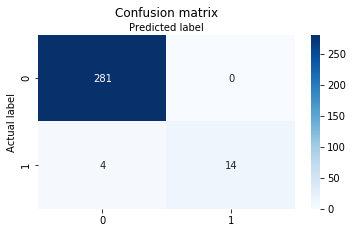

In [13]:
cnf_matrix = metrics.confusion_matrix(y_test, logistic_regression_Y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

No handles with labels found to put in legend.


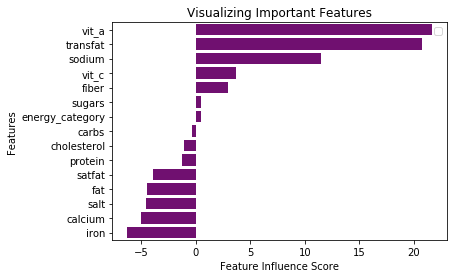

In [50]:
feature_imp = pd.Series(lg_model.coefficients,index = features).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, color = 'purple')

# Add labels to your graph
plt.xlabel('Feature Influence Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Random Forest

### All Features

In [24]:
# %%time

# Set parameters for the Random Forest.
rf_parameters = RandomForestClassifier(maxDepth=10, numTrees=100, impurity="gini", labelCol="general_recipe",
                             featuresCol="feature")#, predictionCol="prediction")

# Fit the model to the data.
rf_model = rf_parameters.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
rf_predictions = rf_model.transform(test_df)

In [25]:
#compare predictions against true labels
rf_predictions.select('fat', 'satfat', 'transfat', 'cholesterol', 'carbs', 'sugars',
                   'fiber', 'protein', 'salt', 'sodium', 'vit_a', 'vit_c', 'calcium',
                   'iron','energy_category','general_recipe','prediction').limit(5).toPandas()

,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,energy_category,general_recipe,prediction
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,1,1.0
1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0.0,1,1.0
2,1,1,0,1,1,1,1,1,1,1,0,1,0,1,2.0,0,0.0
3,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1.0,0,0.0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.0,0,0.0


In [35]:
rf_accuracy = round(evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})*100,2)
rf_f1_score = round(evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})*100,2)

print(rf_accuracy)
print(rf_f1_score)

99.33
99.31


In [97]:
#print evaluation metrics

y_test = test_df.select('general_recipe').toPandas()
random_forest_Y_pred = rf_predictions.select('prediction').toPandas()

print(classification_report(y_test, random_forest_Y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       281
           1       1.00      0.89      0.94        18

   micro avg       0.99      0.99      0.99       299
   macro avg       1.00      0.94      0.97       299
weighted avg       0.99      0.99      0.99       299



Text(0.5, 194.08, 'Predicted label')

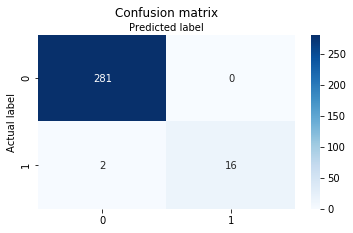

In [98]:
cnf_matrix = metrics.confusion_matrix(y_test, random_forest_Y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
rf_model.featureImportances

SparseVector(15, {0: 0.0507, 1: 0.0862, 2: 0.0566, 3: 0.04, 4: 0.0155, 5: 0.0191, 6: 0.0256, 7: 0.0353, 8: 0.1161, 9: 0.2709, 10: 0.0916, 11: 0.1064, 12: 0.0039, 13: 0.0306, 14: 0.0517})

No handles with labels found to put in legend.


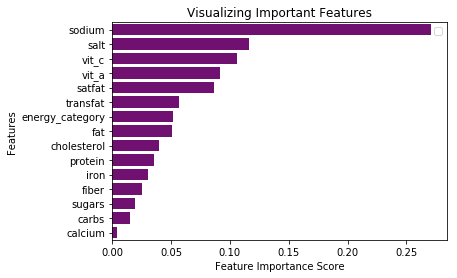

In [92]:
feature_imp = pd.Series(rf_model.featureImportances,index = features).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, color = 'purple')

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Top 5 Features

In [31]:
#gather feature vector and identify features
top_5_features = ['sodium','salt','vit_c','vit_a','satfat']

assembler = VectorAssembler(inputCols = top_5_features, outputCol = 'top_5_features')
pipeline = assembler.transform(ml_data)

#split data into 80% train and 20% test
top_5_train_df, top_5_test_df = pipeline.randomSplit([.8,.2],seed=1234)

In [117]:
top_5_train_df.limit(2).toPandas()

,title,energy,fat,satfat,transfat,cholesterol,carbs,sugars,fiber,protein,salt,sodium,vit_a,vit_c,calcium,iron,rec_type,energy_category,general_recipe,top_5_features
0,10-minute mincemeat,8773.0,1,1,0,1,1,1,1,1,0,0,0,1,0,1,c,2.0,0,"(0.0, 0.0, 1.0, 0.0, 1.0)"
1,15-minute mix & match salad,3347.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,c,0.0,0,"(0.0, 0.0, 0.0, 0.0, 0.0)"


In [32]:
# %%time

# Set parameters for the Random Forest.
top_5_rf_parameters = RandomForestClassifier(maxDepth=10, numTrees=100, impurity="gini", labelCol="general_recipe",
                             featuresCol="top_5_features")#, predictionCol="prediction")

# Fit the model to the data.
top_5_rf_model = top_5_rf_parameters.fit(top_5_train_df)

# Given a dataset, predict each point's label, and show the results.
top_5_rf_predictions = top_5_rf_model.transform(top_5_test_df)

In [119]:
#print evaluation metrics

print(evaluator.evaluate(top_5_rf_predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(top_5_rf_predictions, {evaluator.metricName: "f1"}))

0.9832775919732442
0.9820027426385538


In [34]:
top_5_rf_accuracy = round(evaluator.evaluate(top_5_rf_predictions, {evaluator.metricName: "accuracy"})*100,2)
top_5_rf_f1_score = round(evaluator.evaluate(top_5_rf_predictions, {evaluator.metricName: "f1"})*100,2)

print(top_5_rf_accuracy)
print(top_5_rf_f1_score)

98.33
98.2


In [120]:
#print evaluation metrics

top_5_y_test = top_5_test_df.select('general_recipe').toPandas()
top_5_random_forest_Y_pred = top_5_rf_predictions.select('prediction').toPandas()

print(classification_report(top_5_y_test, top_5_random_forest_Y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       281
           1       1.00      0.72      0.84        18

   micro avg       0.98      0.98      0.98       299
   macro avg       0.99      0.86      0.91       299
weighted avg       0.98      0.98      0.98       299



Text(0.5, 194.08, 'Predicted label')

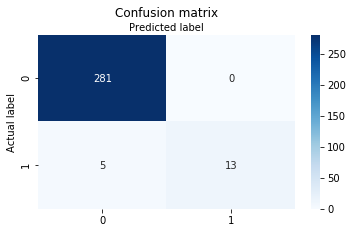

In [121]:
cnf_matrix = metrics.confusion_matrix(top_5_y_test, top_5_random_forest_Y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(5,3))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

No handles with labels found to put in legend.


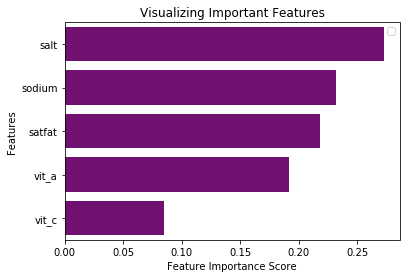

In [123]:
feature_imp = pd.Series(top_5_rf_model.featureImportances,index = top_5_features).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, color = 'purple')

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### Which is the best Model ?

In [39]:
results = pd.DataFrame({
    'Number of Features': [15,15,5],
    'Accuracy': [lg_accuracy, rf_accuracy, top_5_rf_accuracy],
    'F1-Score': [lg_f1_score, rf_f1_score, top_5_rf_f1_score]})
results.index = ['Logistic Regression','Random Forest Classifier', 'Random Forest Classifier']
results.index.name = 'Model'
results

,Number of Features,Accuracy,F1-Score
Model,,,
Logistic Regression,15,98.66,98.58
Random Forest Classifier,15,99.33,99.31
Random Forest Classifier,5,98.33,98.20
